# Intro

Here is a Google Colab Notebook for model testing. Please input the file name you would like to test, and the predictor column. (The file is set for Listeria and Salmonella/Campylobacter)

This is the most up-to-date, tried and tested method I used to develop the baseline code for the model testing AND results.

In this notebook, the exact same models that are provided on the competition, official git repo are used. The code is adapted to perform a grid search (search through a list of hyper parameters) to find the best model results.

I designed it to save all model results into the local files because of the testing we needed to do for my personal project, however, this code can be streamlined by running a Random Search or a pre-packaged, optimized Grid Search instead of the for loops.


NOTE: Please remember to download/save the csv from the Files section on google collab if you want to keep your results.

# How to Run the Models

## STEP 1: Uploading files to run
- Select the files icon and upload the desired file (i.e. SalCampChicken_clean.csv)

## STEP 2: Altering file name, y column/predictor, and other main decisions effecting all models
- Edit the **global variables**.
- NOTE: if you search for STEP 2, the cell(s) where STEP 2 are listed are the cells where you can edit anything!

    

## Optional STEP 3: Editing or adding a hyperparameter(s)
- in each model option (function = *test_"model name"*, i.e. test_knn), edit the hyperparameters to search through
- NOTE: if you search for STEP 3, the cell(s) where STEP 3 are listed are the cells where you can edit anything!
- NOTE: if adding another hyperparameter:
  1) Add the hyperparameter as a list
  2) Add a for loop
  3) Adjust the results_column from STEP 2
  4) Adjust each *test_"Model"*'s results/output to have the hyperparameters, and put np.nan as the output


## Optional STEP 4: Adding a model
1) add the model package to the imports section
2) add a new codeing section
3) name the function *test_"model"* for consistency
4) copy and paste a similar model
5) adjust the hyperparameters, and add or subtract for loops as needed
6) edit the hyperparameter options in the results_column (from STEP\_2) and each of the returning results/outputs in each *test_"model"* function

## STEP 5: Choosing models to run
- in the *run_models_for_file* function, comment or uncomment the lines in the variable **model_fns** to decide which models to run

# STEP 6: Running all cells
- hit the Run all button as listed above



# How to Run the Results (Scroll down to "Analyze Results" section and start there)

## If already have results file and do not want to run the modeling section
- go to the files icon in google colab, and upload the results file

### STEP 1: Change global variables
- edit any of the variables, such as the "primary metric" to be on your visuals

### STEP 2: Runninng analyze
- go through and run cells as needed

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    PrecisionRecallDisplay
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import backend as K
import re
from pathlib import Path, PurePosixPath
from dataclasses import dataclass, asdict
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import json
from sklearn.inspection import permutation_importance
import tempfile
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# This is where modeling begins.

Below, feel free to change test size, column results to save, and the y-col to use.

For salmonella/campylobacter, the possible predictor column of your choosing.

The Salmonella/campylobacter column was created by an OR statement of the Salmonella OR Campylobacter status.

In [2]:
# STEP 2: Edit any of these variables in these sections

# saving global variables
TEST_SIZE = .22  # for validation (Pick a number between .1-.99 to reflect percentage)
RANDOM_STATE = 42  # for repeatability
# developing results table to plot

DATA_PATH = None
# !!!!!! IF YOU ARE RUNNING IN VISUAL STUDIO, UNCOMMENT THE CODE BELOW
# ROOT = Path.cwd()
# if ROOT.name == "preparation":
#     ROOT = ROOT.parent
# DATA = ROOT / "data"


# getting in file path
try:
    file_info = Path(DATA_PATH / "ListeriaSoil_clean_log.csv")
except:
    try:
        file_info = Path("ListeriaSoil_clean_log.csv")
    except Exception as e:
        raise e

Y_COL = "binary_listeria_presense"

# If want all strings/catagorical data to be encoded in 1-hot vectors
# (aka want to transform arbitrary strings into integer values)
ENCODE_STR = False


# Preparing the data

In [3]:
def data_prep(file_info):
    """
    ----- inputs -----
    file_info: Path object
        file wanting to process
    ----- outputs ----
    df: pandas df
        processed anonymzied data (string columns representing intervals split into min and max, then put as minimum and maximum values for those columns)
    """

    df = pd.read_csv(Path(file_info.name))

    # Drop 'index' column if it exists, as it's typically an artifact and not a feature
    if 'index' in df.columns:
        df = df.drop(columns=['index'])

    # if salcamp column, then adding it to the dataset
    if Y_COL == "Salmon_or_camp_test":
        df["Salmon_or_camp_test"] = (df["CampylobacterAnalysis30ml"] == "Positive") | (df["SalmonellaSPAnalysis"] == "Positive")
    if Y_COL == "binary_listeria_presense":
        original_listeria_col = 'Number of Listeria isolates obtained'
        df['binary_listeria_presense'] = [row_val if row_val == 0 else 1 for row_val in df[original_listeria_col]]
        # Drop the original column to prevent data leakage
        if original_listeria_col in df.columns:
            df = df.drop(columns=[original_listeria_col])

    # switching missing values and weird failures in writing to np.inf bc pandas didnt handle properly
    df = df.replace("#NAME?", -np.inf)
    df = df.fillna(-np.inf)

    # replacing inf with max number that is not max number + 100 in dict (FOR NOT JUST 99999999)
    df = df.replace(np.inf, 99999)
    # replacing -inf with min number (not -inf) - 100 in dict (FOR NOT JUST -99999999)
    df = df.replace(-np.inf, -99999)

    # Drop unwanted cluster columns if they exist
    cols_to_drop = ['scaled_cluster_kmeans', 'cluster_kmeans']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

    df = df.dropna(axis=1, how="all")

    if ENCODE_STR:
        df = pd.get_dummies(df)
    return df

# Splitting into Train and Test sets

In [4]:

def get_train_test(
    df, y_col=Y_COL, scaling_used=True
):
    """
    ----- inputs -----
    df: pandas dict
        processed data (all numerics)
    y_col: str
        string of y labels
    test_size: int
        % want test set to be of full data
    scaling_used: boolean
        whether to test scaled data and original data (True) or only original data (False)
    ----- outputs ----
    data_testing: dict[str=scalingType][str=y/X train/test label][pd.DataFrame]
        dictionary contianing
            * string of scaling type (standard scalar, orig)
                * string of what dataset grabbing (X_train, X_test, y_train, y_test)
                    * corresponding data in a pandas dataframe
        "
    """

    # indexes for test set
    X = df.drop(columns=Y_COL)
    y = df[Y_COL]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    # data columns
    data_columns = X.columns

    if scaling_used:  # if want to run on scaled and original data
        # testing all with and without scaled data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.values)
        X_test_scaled = scaler.transform(X_test.values)

        data_testing = {
            "columns": data_columns,
            "standard_scalar": {
                "X_train": X_train_scaled,
                "X_test": X_test_scaled,
                "y_train": y_train,  # using unscaled y
                "y_test": y_test,  # using unscaled y
            },
            "orig": {
                "X_train": X_train,
                "X_test": X_test,
                "y_train": y_train,
                "y_test": y_test,
            },
        }

        return data_testing

    else:  # if only want to run on original data
        data_testing = {
            "columns": data_columns,
            "orig": {
                "X_train": X_train,
                "X_test": X_test,
                "y_train": y_train,
                "y_test": y_test,
            }
        }
        return data_testing


# Modeling Section

In [97]:
def test_svm(data_testing, file_info, model_predictions_data):
    """
    ----- inputs -----
    data_testing: dict[str=scalingType][str=y/X train/test label][pd.DataFrame]
        dictionary contianing
            * string of scaling type (standard scalar, orig)
                * string of what dataset grabbing (X_train, X_test, y_train, y_test)
                    * corresponding data in a pandas dataframe
    model_predictions_data: list
        A list to store dictionaries of y_true and y_pred_proba for PR/AUC curves.
    ----- outputs ----

    """

    # results table
    svm_results = []

    # STEP 3: can edit HYPERPARAMETERs: for svm variables
    c_vals = [1, 4]
    svm_kernels = ['linear', 'rbf']

    # grid searching model results for svm on all types of data with all types of inputs
    for scalar_type in tqdm(data_testing.keys(), desc="svm scaled vs original"):
        if scalar_type == 'columns':
            continue
        X_test = data_testing[scalar_type]["X_test"]
        X_train = data_testing[scalar_type]["X_train"]
        y_train = data_testing[scalar_type]["y_train"]
        y_test = data_testing[scalar_type]["y_test"]
        feature_names = data_testing["columns"].tolist()

        # going through possible svm combos
        for c_val in c_vals:
            for svm_kernel in svm_kernels:
                # modeling portion
                # SVC needs probability=True to use predict_proba, which can be slower
                model = SVC(C=c_val, kernel=svm_kernel, max_iter=20000, probability=True)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class

                # validation
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)
                conf_matrix = confusion_matrix(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_pred_proba)
                pr_auc = average_precision_score(y_test, y_pred_proba)

                # getting feature importance
                coefficients = None
                feature_imp = None
                feature_imp_json = None
                if svm_kernel == 'linear':
                    coefficients = model.coef_.ravel()
                    feature_imp = dict(zip(feature_names, coefficients))
                    feature_imp_json = json.dumps({k: float(v) for k, v in feature_imp.items()})

                # getting permutation importance
                perm = permutation_importance(
                    model, X_test, y_test,
                    n_repeats=3,
                    random_state=RANDOM_STATE,
                    scoring="f1"  # or "accuracy"
                )

                perm_imp = dict(zip(feature_names, perm.importances_mean))
                perm_imp_json = json.dumps({k: float(v) for k, v in perm_imp.items()})

                # STEP 3, add any hyperparameters to each of these results/outputs: saving results to dict
                svm_results.append(
                    {
                        "file name": file_info.name,
                        "accuracy": accuracy,
                        "precision": precision,
                        "recall": recall,
                        "f1": f1,
                        "roc_auc": roc_auc,
                        "pr_auc": pr_auc,
                        "confusion matrix": conf_matrix,
                        "test size": TEST_SIZE,
                        "random state": RANDOM_STATE,
                        "scalar_status": scalar_type,
                        "y variable used": Y_COL,
                        "model used": "svm",
                        "logistic_reg_c": None,
                        "lr_ratios": None,
                        "nn_layers": None,
                        "nn_neurons": None,
                        "nn_batch_size": None,
                        "nn_epochs": None,
                        "dt_max_depth": None,
                        "dt_min_samples_split": None,
                        "svm_c_val": c_val,
                        "svm_kernel": svm_kernel,
                        "knn_weights": None,
                        "gbm_learning_rate": None,
                        "gbm_n_estimator": None,
                        "rf_n_estimators": None,
                        "rf_max_depth": None,
                        "rf_min_samples_leaf": None,
                        "coefficient_importance": feature_imp_json,
                        "permutation_importance": perm_imp_json,
                        "y_test": y_test.tolist(), # Added y_test to results
                        "y_pred_proba": y_pred_proba.tolist(),
                    }
                )

                # Store y_test and y_pred_proba for PR/AUC plotting
                model_predictions_data.append({
                    "file name": file_info.name,
                    "model used": "svm",
                    "scalar_status": scalar_type,
                    "svm_c_val": c_val,
                    "svm_kernel": svm_kernel,
                    "y_test": y_test.tolist(),
                    "y_pred_proba": y_pred_proba.tolist()
                })

    return svm_results

In [98]:
def test_logistic_reg(data_testing, file_info, model_predictions_data):
    """
    ----- inputs -----
    data_testing: dict[str=scalingType][str=y/X train/test label][pd.DataFrame]
        dictionary contianing
            * string of scaling type (standard scalar, orig)
                * string of what dataset grabbing (X_train, X_test, y_train, y_test)
                    * corresponding data in a pandas dataframe
    model_predictions_data: list
        A list to store dictionaries of y_true and y_pred_proba for PR/AUC curves.
    ----- outputs ----

    """

    log_reg_results = []

    # STEP 3: can edit HYPERPARAMETERS: for logistic regression variables
    # c_vals = [0.0001, 0.001, 0.01, 0.1, 1, 2, 4, 8, 32, 56, 100]
    c_vals = [0.01, 0.1, 1, 4, 8]
    # lr_ratios = [0, 0.5, 1] # 0 = l2 penalty, 1 = l1 penalty, 0.5 = elasticnet penalty (both L1 and L2)
    lr_ratios = [
        0,
        1,
    ]  # 0 = l2 penalty, 1 = l1 penalty, 0.5 = elasticnet penalty (both L1 and L2)

    # grid searching model results for log reg on all types of data with all types of inputs
    for scalar_type in tqdm(data_testing.keys(), desc="logistic regression scaled vs original"):

        # breakpoint()

        if scalar_type == 'columns':
            continue
        # print("data testing is :", type(data_testing), " \n", data_testing)
        X_test = data_testing[scalar_type]["X_test"]
        X_train = data_testing[scalar_type]["X_train"]
        y_train = data_testing[scalar_type]["y_train"]
        y_test = data_testing[scalar_type]["y_test"]
        feature_names = data_testing["columns"].tolist()

        # breakpoint()

        # going through possible log reg combos
        for c_val in c_vals:
            for lr_rat in lr_ratios:
                # modeling portion
                model = LogisticRegression(C=c_val, l1_ratio=lr_rat)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class

                # validation
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)
                conf_matrix = confusion_matrix(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_pred_proba)
                pr_auc = average_precision_score(y_test, y_pred_proba)

                # getting feature importance
                coefficients = model.coef_.ravel()
                feature_imp = dict(zip(feature_names, coefficients))
                feature_imp_json = json.dumps({k: float(v) for k, v in feature_imp.items()})

                # getting permutation importance
                perm = permutation_importance(
                    model, X_test, y_test,
                    n_repeats=10,
                    random_state=RANDOM_STATE,
                    scoring="f1"  # or "accuracy"
                )

                perm_imp = dict(zip(feature_names, perm.importances_mean))
                perm_imp_json = json.dumps({k: float(v) for k, v in perm_imp.items()})

                # STEP 3, add any hyperparameters to each of these results/outputs: saving results to dictfile_path: str
                log_reg_results.append(
                    {
                        "file name": file_info.name,
                        "accuracy": accuracy,
                        "precision": precision,
                        "recall": recall,
                        "f1": f1,
                        "roc_auc": roc_auc,
                        "pr_auc": pr_auc,
                        "confusion matrix": conf_matrix,
                        "test size": TEST_SIZE,
                        "random state": RANDOM_STATE,
                        "scalar_status": scalar_type,
                        "y variable used": Y_COL,
                        "model used": "logistic regression",
                        "logistic_reg_c": c_val,
                        "lr_ratios": lr_rat,
                        "nn_layers": np.nan,
                        "nn_neurons": np.nan,
                        "nn_batch_size": np.nan,
                        "nn_epochs": np.nan,
                        "dt_max_depth": np.nan,
                        "dt_min_samples_split": np.nan,
                        "svm_c_val": np.nan,
                        "svm_kernel": np.nan,
                        "knn_n_neighbor": np.nan,
                        "knn_weights": np.nan,
                        "gbm_learning_rate": np.nan,
                        "gbm_n_estimator": np.nan,
                        "rf_n_estimators": np.nan,
                        "rf_max_depth": np.nan,
                        "rf_min_samples_leaf": np.nan,
                        "coefficient_importance": feature_imp_json,
                        "permutation_importance": perm_imp_json,
                        "y_test": y_test.tolist(), # Added y_test to results
                        "y_pred_proba": y_pred_proba.tolist(),
                    }
                )

                # Store y_test and y_pred_proba for PR/AUC plotting
                model_predictions_data.append({
                    "file name": file_info.name,
                    "model used": "logistic regression",
                    "scalar_status": scalar_type,
                    "logistic_reg_c": c_val,
                    "lr_ratios": lr_rat,
                    "y_test": y_test.tolist(),
                    "y_pred_proba": y_pred_proba.tolist()
                })

    return log_reg_results

In [99]:
def test_knn(data_testing, file_info, model_predictions_data):
    """
    ----- inputs -----
    data_testing: dict[str=scalingType][str=y/X train/test label][pd.DataFrame]
        dictionary contianing
            * string of scaling type (standard scalar, orig)
                * string of what dataset grabbing (X_train, X_test, y_train, y_test)
                    * corresponding data in a pandas dataframe
    model_predictions_data: list
        A list to store dictionaries of y_true and y_pred_proba for PR/AUC curves.
    ----- outputs ----

    """

    # results table
    knn_results = []

    # STEP 3: can edit HYPERPARAMETERS: for knn variables
    knn_n_neighbors = [2, 5, 10, 15, 20]
    weights = ['uniform', 'distance']

    # grid searching model results for knn on all types of data with all types of inputs
    for scalar_type in tqdm(data_testing.keys(), desc="knn scaled vs original"):
        if scalar_type == 'columns':
            continue
        X_test = data_testing[scalar_type]["X_test"]
        X_train = data_testing[scalar_type]["X_train"]
        y_train = data_testing[scalar_type]["y_train"]
        y_test = data_testing[scalar_type]["y_test"]
        feature_names = data_testing["columns"].tolist()

        # going through possible KNN combos
        for knn_n_neighbor in knn_n_neighbors:
            for weight in weights:
                # modeling portion
                model = KNeighborsClassifier(
                    n_neighbors=knn_n_neighbor, weights=weight
                )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class

                # validation
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)
                conf_matrix = confusion_matrix(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_pred_proba)
                pr_auc = average_precision_score(y_test, y_pred_proba)

                # getting permutation importance
                perm = permutation_importance(
                    model, X_test, y_test,
                    n_repeats=3, # reduced number to speed things up significantly
                    random_state=RANDOM_STATE,
                    scoring="f1"  # or "accuracy"
                )

                perm_imp = dict(zip(feature_names, perm.importances_mean))
                perm_imp_json = json.dumps({k: float(v) for k, v in perm_imp.items()})

                # STEP 3, add any hyperparameters to each of these results/outputs: saving results to dict
                knn_results.append(
                    {
                        "file name": file_info.name,
                        "accuracy": accuracy,
                        "precision": precision,
                        "recall": recall,
                        "f1": f1,
                        "roc_auc": roc_auc,
                        "pr_auc": pr_auc,
                        "confusion matrix": conf_matrix,
                        "test size": TEST_SIZE,
                        "random state": RANDOM_STATE,
                        "scalar_status": scalar_type,
                        "y variable used": Y_COL,
                        "model used": "knn",
                        "logistic_reg_c": np.nan,
                        "lr_ratios": np.nan,
                        "nn_layers": np.nan,
                        "nn_neurons": np.nan,
                        "nn_batch_size": np.nan,
                        "nn_epochs": np.nan,
                        "dt_max_depth": np.nan,
                        "dt_min_samples_split": np.nan,
                        "svm_c_val": np.nan,
                        "svm_kernel": np.nan,
                        "knn_n_neighbor": knn_n_neighbor,
                        "knn_weights": weight,
                        "gbm_learning_rate": np.nan,
                        "gbm_n_estimator": np.nan,
                        "rf_n_estimators": np.nan,
                        "rf_max_depth": np.nan,
                        "rf_min_samples_leaf": np.nan,
                        "coefficient_importance": np.nan,
                        "permutation_importance": perm_imp_json,
                        "y_test": y_test.tolist(), # Added y_test to results
                        "y_pred_proba": y_pred_proba.tolist(),
                    }
                )

                # Store y_test and y_pred_proba for PR/AUC plotting
                model_predictions_data.append({
                    "file name": file_info.name,
                    "model used": "knn",
                    "scalar_status": scalar_type,
                    "knn_n_neighbor": knn_n_neighbor,
                    "knn_weights": weight,
                    "y_test": y_test.tolist(),
                    "y_pred_proba": y_pred_proba.tolist()
                })

    return knn_results

In [100]:
def test_neural_net(data_testing, file_info, model_predictions_data):
    """
    ----- inputs -----
    data_testing: dict[str=scalingType][str=y/X train/test label][pd.DataFrame]
        dictionary contianing
            * string of scaling type (standard scalar, orig)
                * string of what dataset grabbing (X_train, X_test, y_train, y_test)
                    * corresponding data in a pandas dataframe
    model_predictions_data: list
        A list to store dictionaries of y_true and y_pred_proba for PR/AUC curves.
    ----- outputs ----

    """
    # results table
    neur_net_results = []

    #  STEP 3: can edit HYPERPARAMETERS: for neural net
    nn_layers_list = [1, 2, 3, 4]
    nn_neurons_list = [16, 32, 64, 128, 256]
    nn_batch_size_list = [32, 64, 128, 256]
    nn_epochs_list = [5, 10, 20]

    # grid searching model results for neural net on all types of data with all types of inputs
    for scalar_type in tqdm(data_testing.keys(), desc="neural net scaled vs original"):
        if scalar_type == 'columns':
            continue
        X_test = data_testing[scalar_type]["X_test"]
        X_train = data_testing[scalar_type]["X_train"]
        y_train = data_testing[scalar_type]["y_train"]
        y_test = data_testing[scalar_type]["y_test"]

        # going through possible neural net combos
        for nn_layers in nn_layers_list:
            for nn_neurons in nn_neurons_list:
                for nn_batch_size in nn_batch_size_list:
                    for nn_epochs in nn_epochs_list:
                        # modeling portion
                        model = Sequential()
                        model.add(Input(shape=(X_train.shape[1],)))
                        for _ in range(nn_layers):
                            model.add(Dense(nn_neurons, activation="relu"))
                        model.add(Dense(1, activation="sigmoid"))
                        model.compile(
                            optimizer="adam",
                            loss="binary_crossentropy",
                            metrics=["accuracy"],
                        )
                        model.fit(
                            X_train,
                            y_train,
                            epochs=nn_epochs,
                            batch_size=nn_batch_size,
                            verbose=0,
                        )
                        y_pred_proba = model.predict(X_test).flatten() # Probabilities
                        y_pred = (y_pred_proba > 0.5).astype(int) # Predicted classes

                        # validation
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred, zero_division=0)
                        recall = recall_score(y_test, y_pred, zero_division=0)
                        f1 = f1_score(y_test, y_pred, zero_division=0)
                        conf_matrix = confusion_matrix(y_test, y_pred)
                        roc_auc = roc_auc_score(y_test, y_pred_proba)
                        pr_auc = average_precision_score(y_test, y_pred_proba)

                        # STEP 3, add any hyperparameters to each of these results/outputs: saving results to dict
                        neur_net_results.append(
                            {
                                "file name": file_info.name,
                                "accuracy": accuracy,
                                "precision": precision,
                                "recall": recall,
                                "f1": f1,
                                "roc_auc": roc_auc,
                                "pr_auc": pr_auc,
                                "confusion matrix": conf_matrix,
                                "test size": TEST_SIZE,
                                "random state": RANDOM_STATE,
                                "scalar_status": scalar_type,
                                "y variable used": Y_COL,
                                "model used": "neural net",
                                "logistic_reg_c": np.nan,
                                "lr_ratios": np.nan,
                                "nn_layers": nn_layers,
                                "nn_neurons": nn_neurons,
                                "nn_batch_size": nn_batch_size,
                                "nn_epochs": nn_epochs,
                                "dt_max_depth": np.nan,
                                "dt_min_samples_split": np.nan,
                                "svm_c_val": np.nan,
                                "svm_kernel": np.nan,
                                "knn_n_neighbor": np.nan,
                                "knn_weights": np.nan,
                                "gbm_learning_rate": np.nan,
                                "gbm_n_estimator": np.nan,
                                "rf_n_estimators": np.nan,
                                "rf_max_depth": np.nan,
                                "rf_min_samples_leaf": np.nan,
                                "coefficient_importance": np.nan,
                                "permutation_importance": np.nan,
                                "y_test": y_test.tolist(), # Added y_test to results
                                "y_pred_proba": y_pred_proba.tolist(),
                            }
                        )

                        # Store y_test and y_pred_proba for PR/AUC plotting
                        model_predictions_data.append({
                            "file name": file_info.name,
                            "model used": "neural net",
                            "scalar_status": scalar_type,
                            "nn_layers": nn_layers,
                            "nn_neurons": nn_neurons,
                            "nn_batch_size": nn_batch_size,
                            "nn_epochs": nn_epochs,
                            "y_test": y_test.tolist(),
                            "y_pred_proba": y_pred_proba.tolist()
                        })

    return neur_net_results

In [101]:
def test_gbm(data_testing, file_info, model_predictions_data):
    """
    ----- inputs -----
    data_testing: dict[str=scalingType][str=y/X train/test label][pd.DataFrame]
        dictionary contianing
            * string of scaling type (standard scalar, orig)
                * string of what dataset grabbing (X_train, X_test, y_train, y_test)
                    * corresponding data in a pandas dataframe
    model_predictions_data: list
        A list to store dictionaries of y_true and y_pred_proba for PR/AUC curves.
    ----- outputs ----

    """
    # results table
    gbm_results = []

    #  STEP 3: can edit HYPERPARAMETERS: for gbm variables
    gbm_learning_rates = [0.01, 0.05, 0.1, 0.2]
    gbm_n_estimators = [100, 200, 400, 800]

    # grid searching model results for gbm on all types of data with all types of inputs
    for scalar_type in tqdm(data_testing.keys(), desc="gbm scaled vs original"):
        if scalar_type == 'columns':
            continue
        X_test = data_testing[scalar_type]["X_test"]
        X_train = data_testing[scalar_type]["X_train"]
        y_train = data_testing[scalar_type]["y_train"]
        y_test = data_testing[scalar_type]["y_test"]
        feature_names = data_testing["columns"].tolist()

        # going through possible gbm combos
        for gbm_learning_rate in gbm_learning_rates:
            for gbm_n_estimator in gbm_n_estimators:
                # modeling portion
                model = GradientBoostingClassifier(
                    learning_rate=gbm_learning_rate, n_estimators=gbm_n_estimator
                )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class

                # validation
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)
                conf_matrix = confusion_matrix(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_pred_proba)
                pr_auc = average_precision_score(y_test, y_pred_proba)

                # getting feature importance
                gbm_imp = model.feature_importances_
                feature_imp = dict(zip(feature_names, gbm_imp))
                feature_imp_json = json.dumps({k: float(v) for k, v in feature_imp.items()})

                # getting permutation importance
                perm = permutation_importance(
                    model, X_test, y_test,
                    n_repeats=10,
                    random_state=RANDOM_STATE,
                    scoring="f1"  # or "accuracy"
                )

                perm_imp = dict(zip(feature_names, perm.importances_mean))
                perm_imp_json = json.dumps({k: float(v) for k, v in perm_imp.items()})

                # STEP 3, add any hyperparameters to each of these results/outputs: saving results to dict
                gbm_results.append(
                    {
                        "file name": file_info.name,
                        "accuracy": accuracy,
                        "precision": precision,
                        "recall": recall,
                        "f1": f1,
                        "roc_auc": roc_auc,
                        "pr_auc": pr_auc,
                        "confusion matrix": conf_matrix,
                        "test size": TEST_SIZE,
                        "random state": RANDOM_STATE,
                        "scalar_status": scalar_type,
                        "y variable used": Y_COL,
                        "model used": "gbm",
                        "logistic_reg_c": np.nan,
                        "lr_ratios": np.nan,
                        "nn_layers": np.nan,
                        "nn_neurons": np.nan,
                        "nn_batch_size": np.nan,
                        "nn_epochs": np.nan,
                        "dt_max_depth": np.nan,
                        "dt_min_samples_split": np.nan,
                        "svm_c_val": np.nan,
                        "svm_kernel": np.nan,
                        "knn_n_neighbor": np.nan,
                        "knn_weights": np.nan,
                        "gbm_learning_rate": gbm_learning_rate,
                        "gbm_n_estimator": gbm_n_estimator,
                        "rf_n_estimators": np.nan,
                        "rf_max_depth": np.nan,
                        "rf_min_samples_leaf": np.nan,
                        "coefficient_importance": feature_imp_json,
                        "permutation_importance": perm_imp_json,
                        "y_test": y_test.tolist(), # Added y_test to results
                        "y_pred_proba": y_pred_proba.tolist(),
                    }
                )

                # Store y_test and y_pred_proba for PR/AUC plotting
                model_predictions_data.append({
                    "file name": file_info.name,
                    "model used": "gbm",
                    "scalar_status": scalar_type,
                    "gbm_learning_rate": gbm_learning_rate,
                    "gbm_n_estimator": gbm_n_estimator,
                    "y_test": y_test.tolist(),
                    "y_pred_proba": y_pred_proba.tolist()
                })
    return gbm_results

In [102]:
def test_decision_tree(data_testing, file_info, model_predictions_data):
    """
    ----- inputs -----
    data_testing: dict[str=scalingType][str=y/X train/test label][pd.DataFrame]
        dictionary contianing
            * string of scaling type (standard scalar, orig)
                * string of what dataset grabbing (X_train, X_test, y_train, y_test)
                    * corresponding data in a pandas dataframe
    model_predictions_data: list
        A list to store dictionaries of y_true and y_pred_proba for PR/AUC curves.
    ----- outputs ----

    """
    # results table
    dec_tree_results = []

    #  STEP 3: can edit HYPERPARAMETERS: for decision tree variables
    dt_max_depths = [50, 100, 200, 400, None]
    dt_min_samples_splits = [2, 10, 20, 50]

    # grid searching model results for decision tree on all types of data with all types of inputs
    for scalar_type in tqdm(data_testing.keys(), desc="decision tree scaled vs original"):
        if scalar_type == 'columns':
            continue
        X_test = data_testing[scalar_type]["X_test"]
        X_train = data_testing[scalar_type]["X_train"]
        y_train = data_testing[scalar_type]["y_train"]
        y_test = data_testing[scalar_type]["y_test"]
        feature_names = data_testing["columns"].tolist()

        # going through possible decision tree combos
        for dt_min_samples_split in dt_min_samples_splits:
            for dt_max_depth in dt_max_depths:
                # modeling portion
                model = DecisionTreeClassifier(
                    max_depth=dt_max_depth, min_samples_split=dt_min_samples_split
                )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class

                # validation
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)
                conf_matrix = confusion_matrix(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_pred_proba)
                pr_auc = average_precision_score(y_test, y_pred_proba)

                # getting feature importance
                tree_imp = model.feature_importances_
                feature_imp = dict(zip(feature_names, tree_imp))
                feature_imp_json = json.dumps({k: float(v) for k, v in feature_imp.items()})

                # getting permutation importance
                perm = permutation_importance(
                    model, X_test, y_test,
                    n_repeats=10,
                    random_state=RANDOM_STATE,
                    scoring="f1"  # or "accuracy"
                )

                perm_imp = dict(zip(feature_names, perm.importances_mean))
                perm_imp_json = json.dumps({k: float(v) for k, v in perm_imp.items()})

                # STEP 3, add any hyperparameters to each of these results/outputs
                dec_tree_results.append(
                    {
                        "file name": file_info.name,
                        "accuracy": accuracy,
                        "precision": precision,
                        "recall": recall,
                        "f1": f1,
                        "roc_auc": roc_auc,
                        "pr_auc": pr_auc,
                        "confusion matrix": conf_matrix,
                        "test size": TEST_SIZE,
                        "random state": RANDOM_STATE,
                        "scalar_status": scalar_type,
                        "y variable used": Y_COL,
                        "model used": "decision_tree",
                        "logistic_reg_c": np.nan,
                        "lr_ratios": np.nan,
                        "nn_layers": np.nan,
                        "nn_neurons": np.nan,
                        "nn_batch_size": np.nan,
                        "nn_epochs": np.nan,
                        "dt_max_depth": dt_max_depth,
                        "dt_min_samples_split": dt_min_samples_split,
                        "svm_c_val": np.nan,
                        "svm_kernel": np.nan,
                        "knn_n_neighbor": np.nan,
                        "knn_weights": np.nan,
                        "gbm_learning_rate": np.nan,
                        "gbm_n_estimator": np.nan,
                        "rf_n_estimators": np.nan,
                        "rf_max_depth": np.nan,
                        "rf_min_samples_leaf": np.nan,
                        "coefficient_importance": feature_imp_json,
                        "permutation_importance": perm_imp_json,
                        "y_test": y_test.tolist(), # Added y_test to results
                        "y_pred_proba": y_pred_proba.tolist(),
                    }
                )

                # Store y_test and y_pred_proba for PR/AUC plotting
                model_predictions_data.append({
                    "file name": file_info.name,
                    "model used": "decision_tree",
                    "scalar_status": scalar_type,
                    "dt_max_depth": dt_max_depth,
                    "dt_min_samples_split": dt_min_samples_split,
                    "y_test": y_test.tolist(),
                    "y_pred_proba": y_pred_proba.tolist()
                })

    return dec_tree_results

In [103]:
def test_random_forest(data_testing, file_info, model_predictions_data):
    """
    ----- inputs -----
    data_testing: dict[str=scalingType][str=y/X train/test label][pd.DataFrame],
        dictionary contianing,
            * string of scaling type (standard scalar, orig),
                * string of what dataset grabbing (X_train, X_test, y_train, y_test),
                    * corresponding data in a pandas dataframe,
    model_predictions_data: list
        A list to store dictionaries of y_true and y_pred_proba for PR/AUC curves.
    ----- outputs -----
    """
    # results table
    rf_results = []

    # STEP 3: edit HYPERPARAMETERS for random forest
    # Expanded hyperparameter search space
    rf_n_estimators = [100, 300, 500]
    rf_max_depths = [None, 10, 50]
    rf_min_samples_leaf = [1, 2, 4]
    #rf_min_samples_split = [2, 5, 10]

    for scalar_type in tqdm(data_testing.keys(), desc="random forest scaled vs original"):
        if scalar_type == 'columns':
            continue
        X_test = data_testing[scalar_type]["X_test"]
        X_train = data_testing[scalar_type]["X_train"]
        y_train = data_testing[scalar_type]["y_train"]
        y_test = data_testing[scalar_type]["y_test"]
        feature_names = data_testing["columns"].tolist()

        # Diagnostic prints (optional, can be removed once issue is resolved)
        print(f"\n--- Diagnosing {scalar_type} for Random Forest ---")
        print(f"X_train shape: {X_train.shape}")
        print(f"y_train shape: {y_train.shape}")
        print(f"X_test shape: {X_test.shape}")
        print(f"y_test shape: {y_test.shape}")

        for rf_n_estimator in rf_n_estimators:
            for rf_max_depth in rf_max_depths:
                for rf_min_leaf in rf_min_samples_leaf:
                        model = RandomForestClassifier(
                                n_estimators=rf_n_estimator,
                                max_depth=rf_max_depth,
                                min_samples_leaf=rf_min_leaf,
                                random_state=RANDOM_STATE,
                                n_jobs=-1
                        )
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                        y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class

                        # validation
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred, zero_division=0)
                        recall = recall_score(y_test, y_pred, zero_division=0)
                        f1 = f1_score(y_test, y_pred, zero_division=0)
                        conf_matrix = confusion_matrix(y_test, y_pred)
                        roc_auc = roc_auc_score(y_test, y_pred_proba)
                        pr_auc = average_precision_score(y_test, y_pred_proba)

                        # getting feature importance
                        rf_imp = model.feature_importances_
                        feature_imp = dict(zip(feature_names, rf_imp))
                        feature_imp_json = json.dumps({k: float(v) for k, v in feature_imp.items()})

                        # getting permutation importance
                        perm = permutation_importance(
                          model, X_test, y_test,
                          n_repeats=3,
                          random_state=RANDOM_STATE,
                          scoring="f1"  # or "accuracy"
                        )

                        perm_imp = dict(zip(feature_names, perm.importances_mean))
                        perm_imp_json = json.dumps({k: float(v) for k, v in perm_imp.items()})

                        # STEP 3, add any hyperparameters to each of these results/outputs
                        rf_results.append(
                            {
                                "file name": file_info.name,
                                "accuracy": accuracy,
                                "precision": precision,
                                "recall": recall,
                                "f1": f1,
                                "roc_auc": roc_auc,
                                "pr_auc": pr_auc,
                                "confusion matrix": conf_matrix,
                                "test size": TEST_SIZE,
                                "random state": RANDOM_STATE,
                                "scalar_status": scalar_type,
                                "y variable used": Y_COL,
                                "model used": "random_forest",
                                "logistic_reg_c": np.nan,
                                "lr_ratios": np.nan,
                                "nn_layers": np.nan,
                                "nn_neurons": np.nan,
                                "nn_batch_size": np.nan,
                                "nn_epochs": np.nan,
                                "dt_max_depth": np.nan,
                                "dt_min_samples_split": np.nan,
                                "svm_c_val": np.nan,
                                "svm_kernel": np.nan,
                                "knn_n_neighbor": np.nan,
                                "knn_weights": np.nan,
                                "gbm_learning_rate": np.nan,
                                "gbm_n_estimator": np.nan,
                                "rf_n_estimators": rf_n_estimator,
                                "rf_max_depth": rf_max_depth,
                                "rf_min_samples_leaf": rf_min_leaf,
                                "coefficient_importance": feature_imp_json,
                                "permutation_importance": perm_imp_json,
                                "y_test": y_test.tolist(), # Added y_test to results
                                "y_pred_proba": y_pred_proba.tolist(),
                            }
                        )

                        # Store y_test and y_pred_proba for PR/AUC plotting
                        model_predictions_data.append({
                            "file name": file_info.name,
                            "model used": "random_forest",
                            "scalar_status": scalar_type,
                            "rf_n_estimators": rf_n_estimator,
                            "rf_max_depth": rf_max_depth,
                            "rf_min_samples_leaf": rf_min_leaf,
                            "y_test": y_test.tolist(),
                            "y_pred_proba": y_pred_proba.tolist()
                        })

    return rf_results

# Prepping the models to Run

In [5]:
def run_models_for_file(file_info, model_predictions_data) -> list:
    """
    Goal: return model results for file

    Paramaters:
        file: str
            the name of the file want to model
        file_info: Path object
            parsed information about the file
        model_predictions_data: list
            A list to store dictionaries of y_true and y_pred_proba for PR/AUC curves.

    Outputs:
        all_rows: list
            list of the dictionary model results
    """

    df = data_prep(file_info)
    if df.empty:
        return []

    data_testing = get_train_test(df, y_col=Y_COL, scaling_used=True)

    # STEP 5: Choosing which model results to run (comment or uncomment models as needed)
    # STEP 4: Add model name here if needed
    model_fns = [
          test_logistic_reg,
          test_neural_net,
          test_knn,
          test_decision_tree,
          test_random_forest,
          test_svm,
          test_gbm,
    ]

    # running each model in the model funcs list to return the results
    all_rows = []
    for fn in model_fns:
        rows = fn(data_testing, file_info, model_predictions_data) # running each function
        if rows:
            all_rows.extend(rows)

    return all_rows

# Running all Models

In [6]:
# Initialize a list to store y_test and y_pred_proba for PR/AUC plotting
model_predictions_data = []

# running each model to get results
rows_results = run_models_for_file(file_info, model_predictions_data) # calling function to run models
dataframe_rows_results = pd.DataFrame(rows_results) # converting into a dataframe, so that we can save it
dataframe_rows_results.to_csv(f'results_for_{file_info.name}') # saving it into the files section as a CSV
print("\n\nCOMPLETED: k\n\n")

FileNotFoundError: [Errno 2] No such file or directory: 'ListeriaSoil_clean_log.csv'

# Analyzing Results

In [108]:
# imports
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import re
import json
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay


In [109]:
# STEP 1 for analyze results global variables!
results_df = pd.read_csv(f"results_for_{file_info.name}")

hyperparam_cols = [
    "logistic_reg_c", "lr_ratios",
    "nn_layers", "nn_neurons", "nn_batch_size", "nn_epochs",
    "dt_max_depth", "dt_min_samples_split",
    "svm_c_val", "svm_kernel",
    "knn_n_neighbor", "knn_metric",
    "gbm_learning_rate", "gbm_n_estimator",
    "rf_n_estimators", "rf_max_depth", "rf_min_samples_leaf"
]

# Base grouping keys
base_cols = ["model used", "scalar_status"]
# DO NOT CHANGE THE LINE BELOW: This defines a "hyperparam combo"
combo_cols = base_cols + hyperparam_cols

# whatever you want your graphs to be looking at
primary_metric = 'accuracy'

## Helper functions for analyzing results

In [110]:
def parse_confusion_matrix(cm_str):
    """
    Parses strings like:
      '[[0 7]\n [0 8]]'
      '[[7 0]\n [8 0]]'
    Returns tn, fp, fn, tp as ints, or NaNs if missing.
    """
    if pd.isna(cm_str):
        return np.nan, np.nan, np.nan, np.nan

    s = str(cm_str).strip()

    # extract 4 integers in row-major order
    nums = re.findall(r"-?\d+", s)
    if len(nums) < 4:
        return np.nan, np.nan, np.nan, np.nan

    tn, fp, fn, tp = map(int, nums[:4])
    return tn, fp, fn, tp

def safe_div(a, b):
    return np.where(b == 0, np.nan, a / b)

In [111]:
def add_derived_columns(df):
    # Parse confusion matrix
    tn_fp_fn_tp = df["confusion matrix"].apply(parse_confusion_matrix)
    df[["tn", "fp", "fn", "tp"]] = pd.DataFrame(tn_fp_fn_tp.tolist(), index=df.index)

    # test n (prefer your stored test size; otherwise derive from cm)
    df["n_test_cm"] = df[["tn", "fp", "fn", "tp"]].sum(axis=1)
    df["n_test"] = df["n_test_cm"] #This line was edited to fix the proportion of predicted positive rate

    # getting rate metrics!
    df["tpr_recall"] = safe_div(df["tp"], (df["tp"] + df["fn"]))
    df["tnr_specificity"] = safe_div(df["tn"], (df["tn"] + df["fp"]))
    df["fpr"] = safe_div(df["fp"], (df["fp"] + df["tn"]))
    df["pred_pos_rate"] = safe_div((df["tp"] + df["fp"]), df["n_test"])
    df["prevalence"] = safe_div((df["tp"] + df["fn"]), df["n_test"])

    df["balanced_accuracy"] = 0.5 * (df["tpr_recall"] + df["tnr_specificity"])

    # Degenerate predictor flags
    df["degenerate_all_pos"] = (df["tn"] == 0) & (df["fn"] == 0) & df["n_test"].notna()
    df["degenerate_all_neg"] = (df["tp"] == 0) & (df["fp"] == 0) & df["n_test"].notna()

    # clean model name
    df["model used"] = df["model used"].astype(str).str.strip().str.lower()
    return df

# Immediately adding the parsed cols
results_df = add_derived_columns(results_df)

In [112]:
summary_stats = results_df.groupby(['model used', 'scalar_status'])[['accuracy', 'precision', 'recall', 'f1']].mean()
print("Summary Statistics of Performance Metrics for Each Model:")
print(summary_stats)

Summary Statistics of Performance Metrics for Each Model:
                                     accuracy  precision    recall        f1
model used          scalar_status                                           
decision_tree       orig             0.756934   0.832100  0.704605  0.762269
                    standard_scalar  0.756569   0.832079  0.703947  0.761926
gbm                 orig             0.847172   0.870554  0.851974  0.861038
                    standard_scalar  0.843522   0.867228  0.848684  0.857720
knn                 orig             0.694161   0.735700  0.700000  0.715185
                    standard_scalar  0.772993   0.785762  0.821053  0.799943
logistic regression orig             0.648175   0.715213  0.607895  0.657177
                    standard_scalar  0.821898   0.831023  0.852632  0.841609
neural net          orig             0.580839   0.655376  0.565406  0.570125
                    standard_scalar  0.754106   0.788963  0.764693  0.771589
random_forest     

In [113]:
# Container for the best probabilities
best_model_probabilities = {}

# Ensure the column exists
if 'y_pred_proba' not in results_df.columns:
    print("Error: 'y_pred_proba' column not found in results_df. Please re-run the models to generate probabilities.")
else:
    print(f"Extracting probabilities for best models based on {primary_metric}...")

    # 1. Identify best models
    # Group by model type and scalar status, then find the row with max primary_metric
    # We use .reset_index() to keep the index accessible
    best_indices = results_df.groupby(['model used', 'scalar_status'])[primary_metric].idxmax()
    best_rows = results_df.loc[best_indices]

    for index, row in best_rows.iterrows():
        model_name = row['model used']
        scalar = row['scalar_status']
        score = row[primary_metric]

        # 2. Extract and parse probabilities
        prob_str = row.get('y_pred_proba')

        if pd.isna(prob_str):
            continue

        try:
            # If loaded from CSV, it's a string representation of a list
            if isinstance(prob_str, str):
                probs = json.loads(prob_str)
            else:
                # If the dataframe is fresh from memory, it might already be a list
                probs = prob_str

            key = f"{model_name} ({scalar})"
            best_model_probabilities[key] = probs
            print(f"Stored probs for {key:<30} (Score: {score:.4f})")

        except Exception as e:
            print(f"Error parsing probabilities for {model_name}: {e}")

# Example usage:
# probs = best_model_probabilities.get('random_forest (orig)')

Extracting probabilities for best models based on accuracy...
Stored probs for decision_tree (orig)           (Score: 0.7956)
Stored probs for decision_tree (standard_scalar) (Score: 0.7883)
Stored probs for gbm (orig)                     (Score: 0.8759)
Stored probs for gbm (standard_scalar)          (Score: 0.8759)
Stored probs for knn (orig)                     (Score: 0.7810)
Stored probs for knn (standard_scalar)          (Score: 0.8175)
Stored probs for logistic regression (orig)     (Score: 0.6496)
Stored probs for logistic regression (standard_scalar) (Score: 0.8467)
Stored probs for neural net (orig)              (Score: 0.7080)
Stored probs for neural net (standard_scalar)   (Score: 0.8978)
Stored probs for random_forest (orig)           (Score: 0.8467)
Stored probs for random_forest (standard_scalar) (Score: 0.8467)
Stored probs for svm (orig)                     (Score: 0.6277)
Stored probs for svm (standard_scalar)          (Score: 0.8686)


## Graphing Results

Text(0.5, 1.0, 'Degenerate check: predicted positive rate vs accuracy')

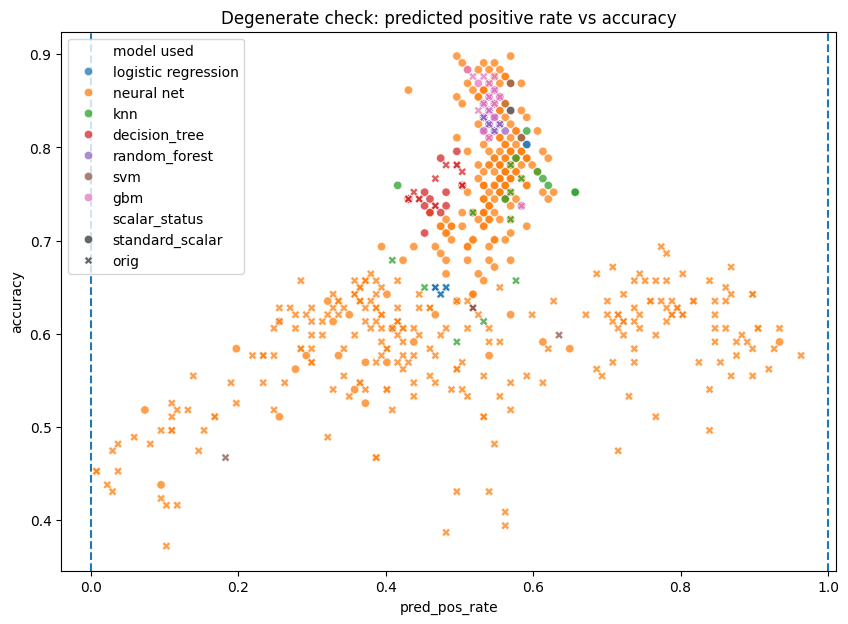

In [92]:
tmp = results_df.dropna(subset=["pred_pos_rate", primary_metric]).copy()

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=tmp,
    x="pred_pos_rate",
    y=primary_metric,
    hue="model used",
    style="scalar_status" if "scalar_status" in tmp.columns else None,
    alpha=0.75,
)
plt.axvline(0.0, linestyle="--")
plt.axvline(1.0, linestyle="--")
plt.title(f"Degenerate check: predicted positive rate vs {primary_metric}")

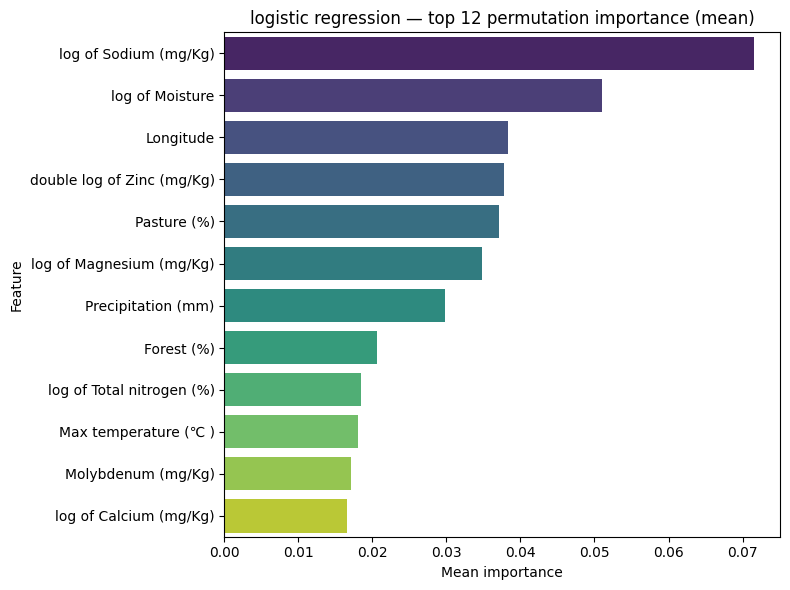

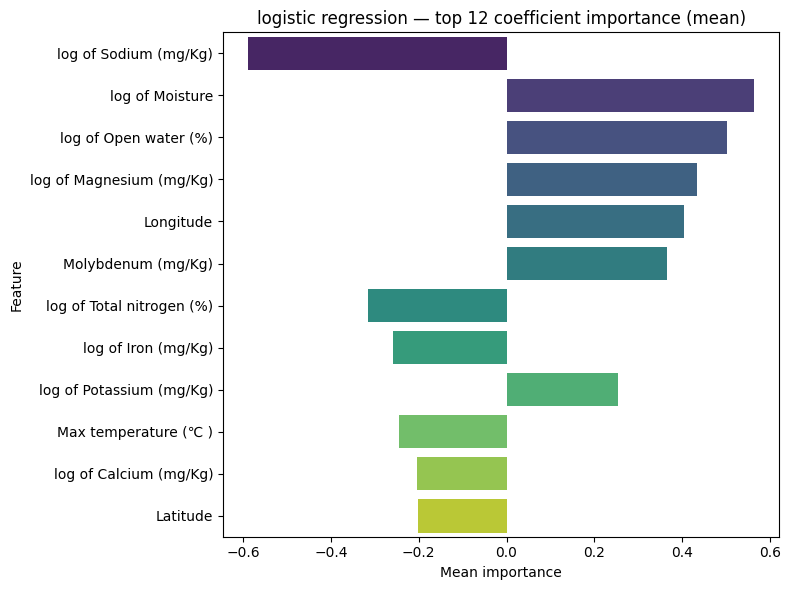

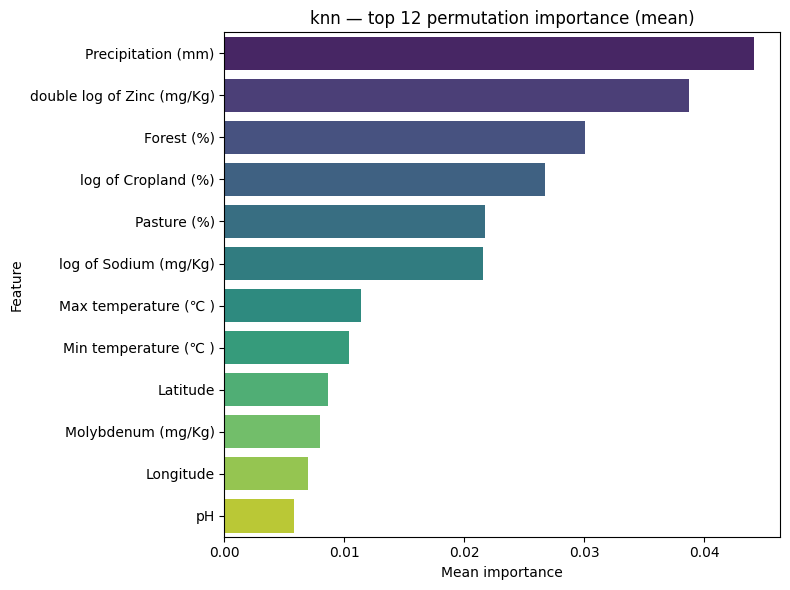

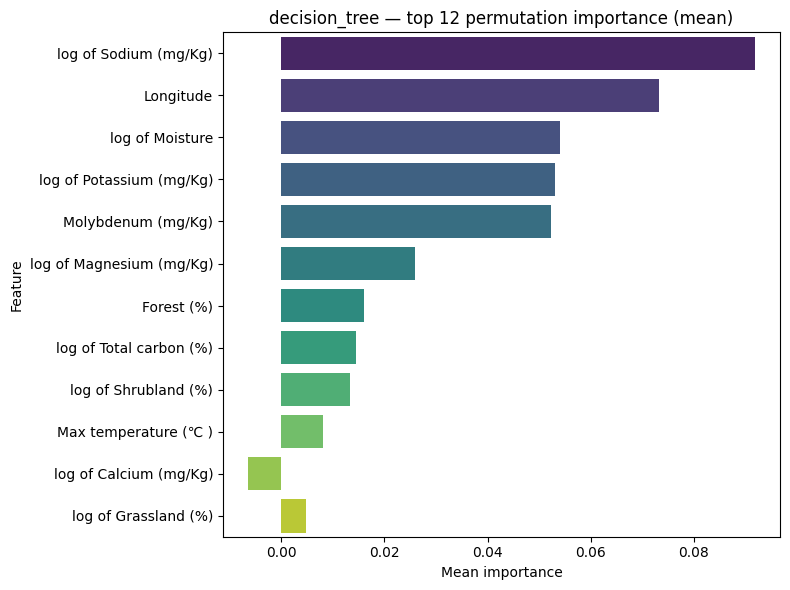

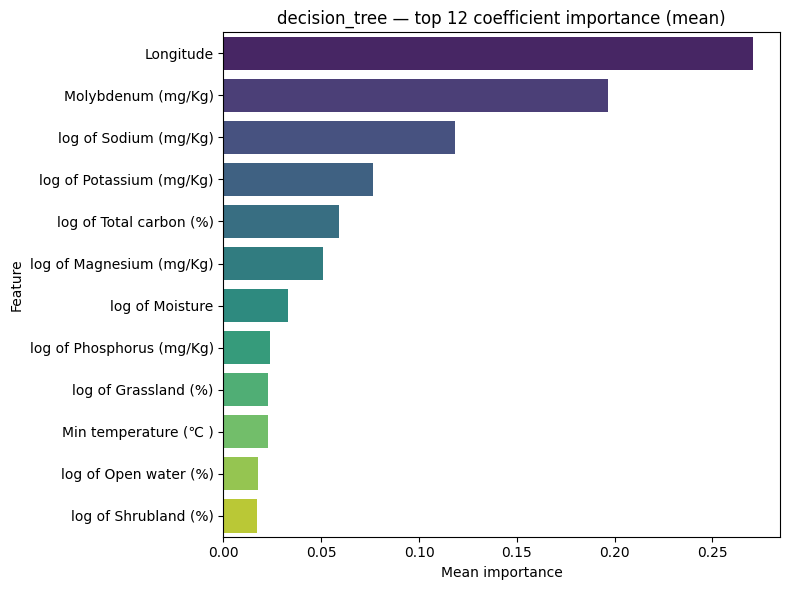

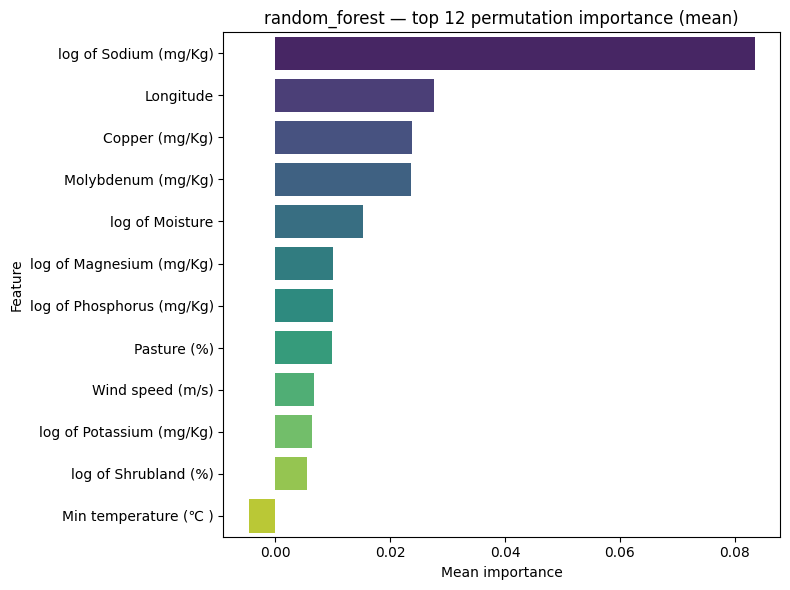

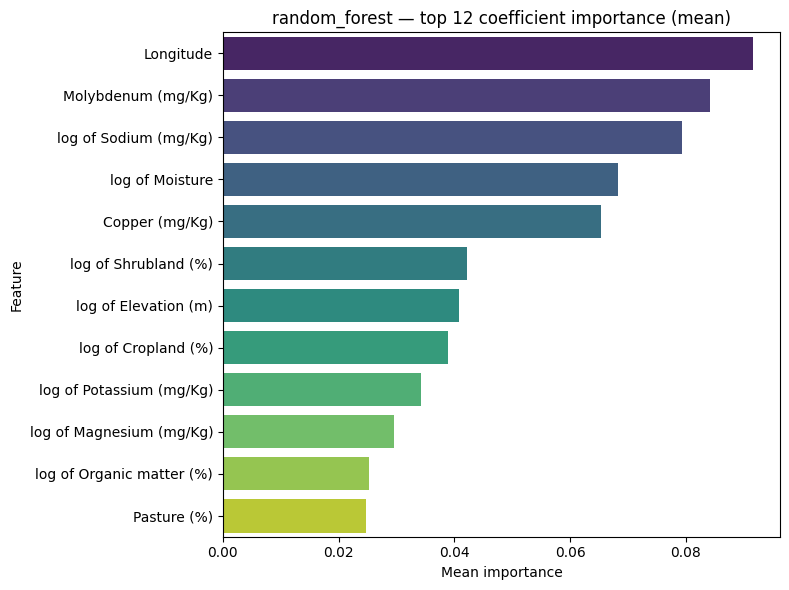

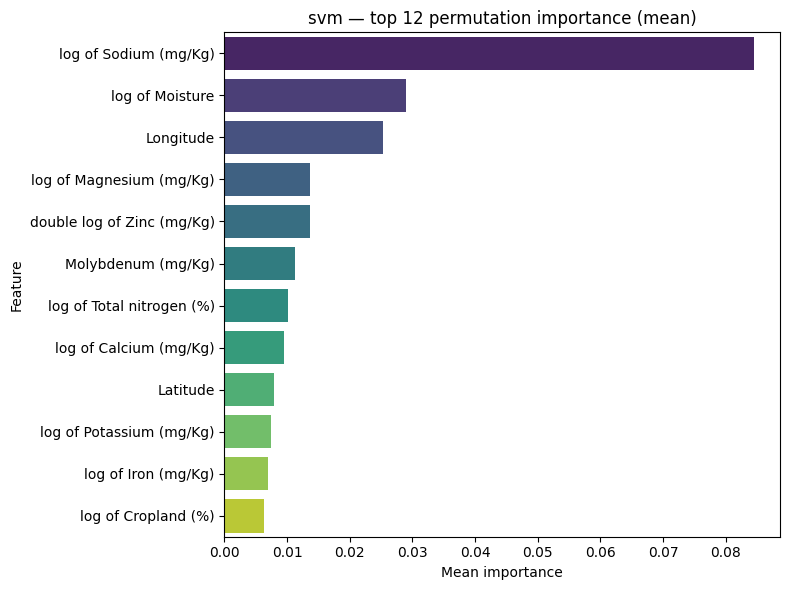

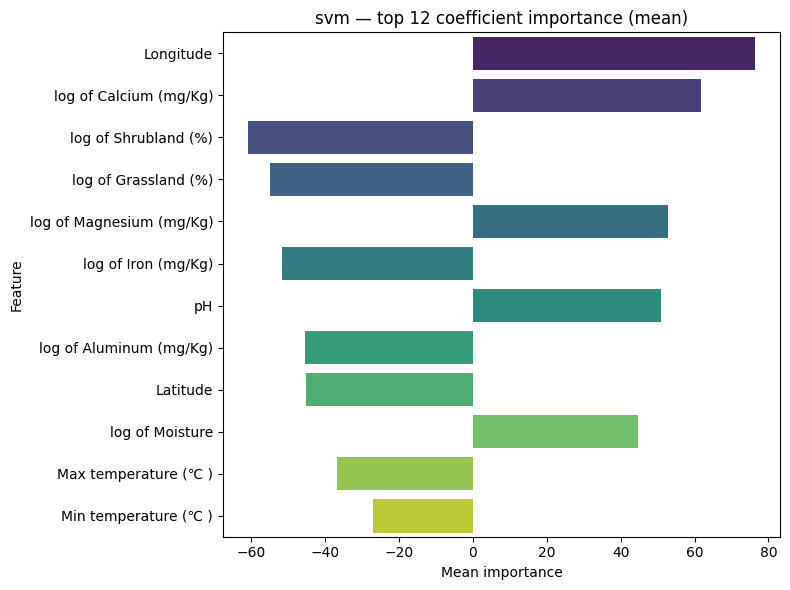

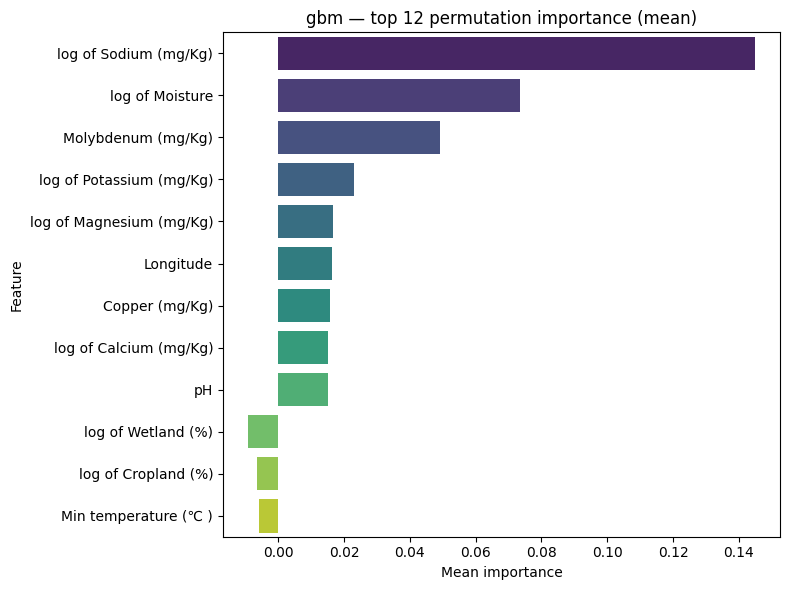

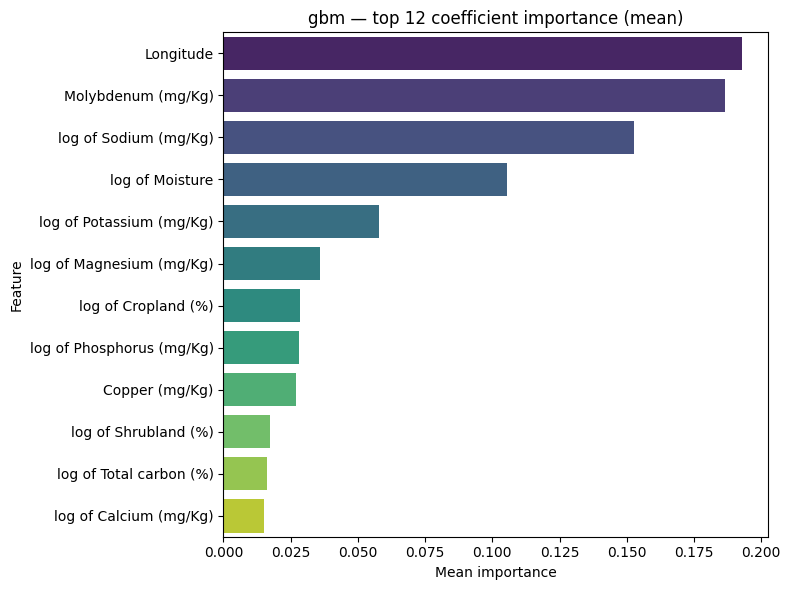

In [93]:
def plot_feature_importances(df, model_name, importance_col='permutation_importance', top_n=12):
    """
    Aggregates and plots mean feature importance for a given model.
    importance_col: 'permutation_importance' or 'coefficient_importance'.
    """
    # Filter the DataFrame for the specific model and where the importance column is not NaN
    subset = df[(df['model used'] == model_name) & df[importance_col].notna()]
    # No data to plot if the subset is empty
    if subset.empty:
        return

    rows = []
    # Iterate through each row in the filtered subset
    for _, row in subset.iterrows():
        # Parsing the importance string (which is JSON) into a dictionary
        try:
            val_str = row[importance_col]
            if pd.isna(val_str): continue
            imp_dict = json.loads(str(val_str))
        except Exception:
            continue
        # For each feature and its value in the importance dictionary
        for feat, val in imp_dict.items():
            # Append a dictionary with the feature and its importance to the rows list
            rows.append({'feature': feat, 'importance': val})

    if not rows:
        return

    # Create a DataFrame from the extracted feature importances
    # Group by feature, calculate the mean importance
    agg_df = pd.DataFrame(rows).groupby('feature')['importance'].mean()

    # Sort by absolute magnitude to capture strong negative coefficients
    agg_df_abs = agg_df.abs().sort_values(ascending=False).head(top_n)

    # Select the original values for those top N features (to show sign)
    imp_df = agg_df.loc[agg_df_abs.index]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=imp_df.values, y=imp_df.index, hue=imp_df.index, palette='viridis', legend=False)
    plt.title(f"{model_name} — top {top_n} {importance_col.replace('_', ' ')} (mean)")
    plt.xlabel('Mean importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Generate plots for each model present in the results_df
models = results_df['model used'].dropna().unique() if 'model used' in results_df.columns else []
for m in models:
    # If 'permutation_importance' column exists, plot permutation importances
    if 'permutation_importance' in results_df.columns:
        plot_feature_importances(results_df, m, 'permutation_importance', top_n=12)
    # If 'coefficient_importance' column exists, plot coefficient importances
    if 'coefficient_importance' in results_df.columns:
        plot_feature_importances(results_df, m, 'coefficient_importance', top_n=12)

## AUC and Precision-Recall Curves

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:255: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower left")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:255: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower left")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:255: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower left")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:255: UserWarnin

PR Curve - decision_tree (orig)
Best accuracy: 0.7956
MaxDepth=400.0 MinSplit=10 - AUC: 0.8193

PR Curve - decision_tree (standard_scalar)
Best accuracy: 0.7883
MaxDepth=50.0 MinSplit=10 - AUC: 0.8173

PR Curve - gbm (orig)
Best accuracy: 0.8759
LR=0.10 N_Estimators=800 - AUC: 0.9472

PR Curve - gbm (standard_scalar)
Best accuracy: 0.8759
LR=0.20 N_Estimators=800 - AUC: 0.9439

PR Curve - knn (orig)
Best accuracy: 0.7810
Neighbors=2 Weights=distance - AUC: 0.7745

PR Curve - knn (standard_scalar)
Best accuracy: 0.8175
Neighbors=2 Weights=distance - AUC: 0.8538

PR Curve - logistic regression (orig)
Best accuracy: 0.6496
C=0.01 L1_ratio=0.00 - AUC: 0.7013

PR Curve - logistic regression (standard_scalar)
Best accuracy: 0.8467
C=4.00 L1_ratio=0.00 - AUC: 0.9111

PR Curve - neural net (orig)
Best accuracy: 0.7080
Layers=4 Neurons=64 Batch=64 Epochs=5 - AUC: 0.5942

PR Curve - neural net (standard_scalar)
Best accuracy: 0.8978
Layers=2 Neurons=256 Batch=64 Epochs=20 - AUC: 0.9433

PR Curve

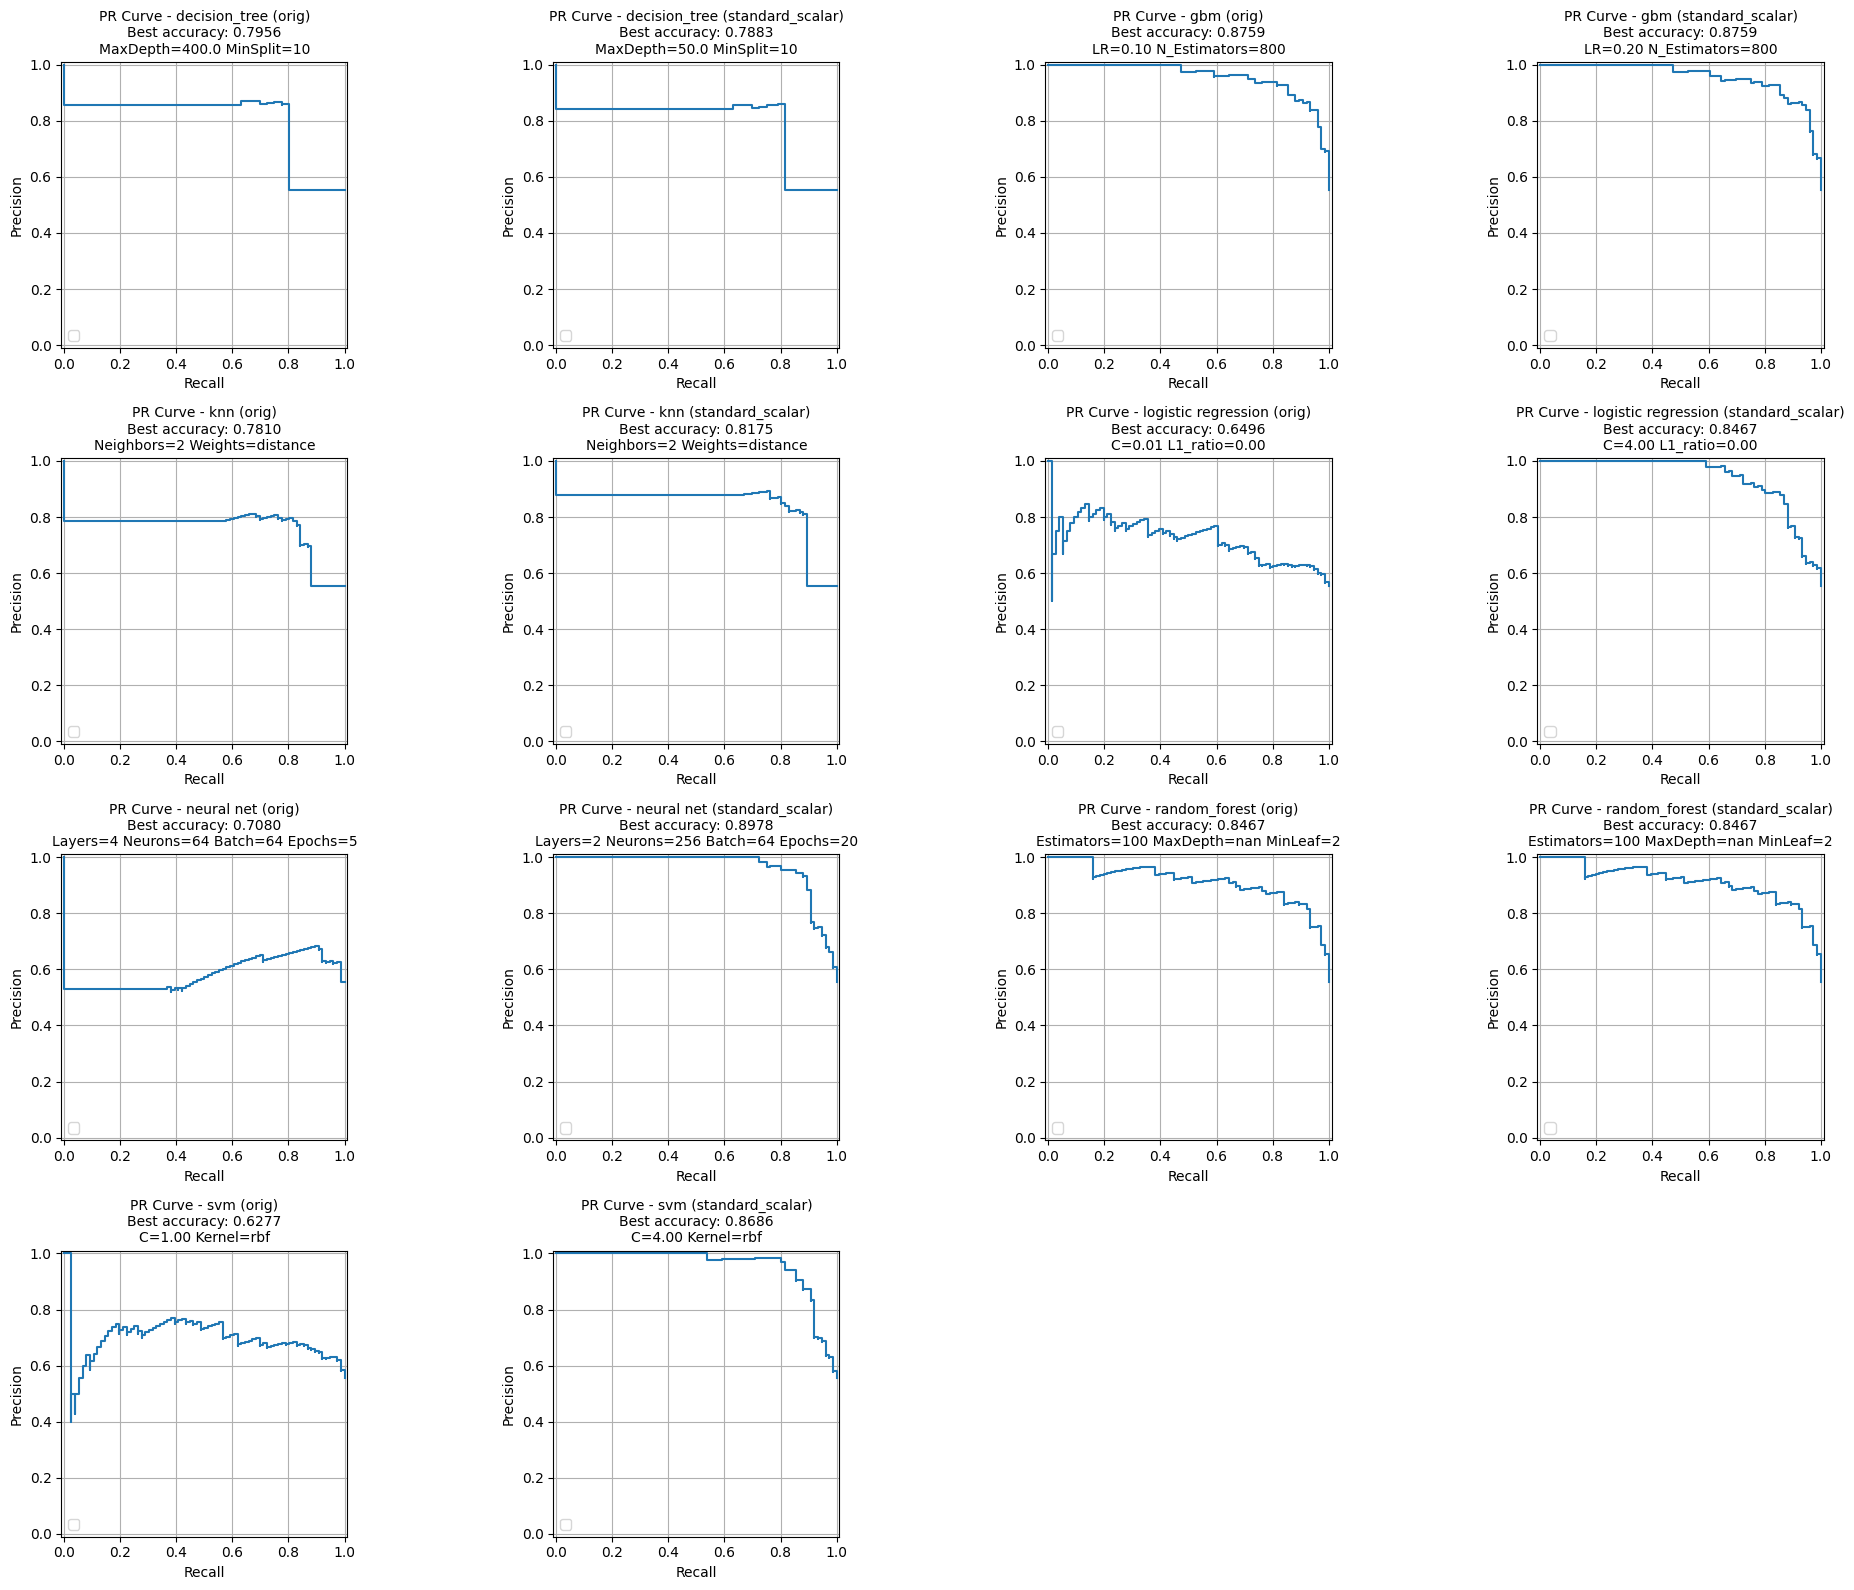

In [107]:
# Helper function to plot PR curve on a given axis
def plot_pr_curve_on_ax(y_test, y_pred_proba, title, ax):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name="").plot(ax=ax)
    ax.set_title(title, fontsize=10) # Smaller font for subplot titles
    ax.grid(True)

# Find the best model for each type based on primary_metric
best_models = results_df.loc[results_df.groupby(['model used', 'scalar_status'])[primary_metric].idxmax()]

# Prepare for subplots
num_plots = len(best_models)
if num_plots == 0:
    print("No best models found to plot PR curves.")
else:
    # Calculate grid dimensions for subplots
    num_cols = int(np.ceil(np.sqrt(num_plots))) # Try for a square layout
    num_rows = int(np.ceil(num_plots / num_cols))

    # Create figure and a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
    # Flatten the axes array to easily iterate, handle case of single subplot
    axes = axes.flatten() if num_plots > 1 else [axes]

    plot_idx = 0
    # Loop through each stored prediction and plot PR curve
    for _, row in best_models.iterrows():
        model_name = row['model used']
        scalar_status = row['scalar_status']

        # Reconstruct hyperparameter information from the row
        # This part is similar to the previous logic but now we're directly using the 'best_models' rows
        y_test = np.array(json.loads(row['y_test']))
        y_pred_proba = np.array(json.loads(row['y_pred_proba']))

        # Construct title dynamically based on model and hyperparameters
        title = f"""PR Curve - {model_name} ({scalar_status})
Best {primary_metric}: {row[primary_metric]:.4f}"""

        # Add hyperparameters to the title
        if model_name == "logistic regression":
            title += f"\nC={row['logistic_reg_c']:.2f} L1_ratio={row['lr_ratios']:.2f}"
        elif model_name == "neural net":
            title += f"\nLayers={int(row['nn_layers'])} Neurons={int(row['nn_neurons'])} Batch={int(row['nn_batch_size'])} Epochs={int(row['nn_epochs'])}"
        elif model_name == "knn":
            title += f"\nNeighbors={int(row['knn_n_neighbor'])} Weights={row['knn_weights']}"
        elif model_name == "decision_tree":
            title += f"\nMaxDepth={row['dt_max_depth']} MinSplit={int(row['dt_min_samples_split'])}"
        elif model_name == "random_forest":
            title += f"\nEstimators={int(row['rf_n_estimators'])} MaxDepth={row['rf_max_depth']} MinLeaf={int(row['rf_min_samples_leaf'])}"
        elif model_name == "svm":
            title += f"\nC={row['svm_c_val']:.2f} Kernel={row['svm_kernel']}"
        elif model_name == "gbm":
            title += f"\nLR={row['gbm_learning_rate']:.2f} N_Estimators={int(row['gbm_n_estimator'])}"

        plot_pr_curve_on_ax(y_test, y_pred_proba, title, axes[plot_idx])

        # Calculate and print AUC
        auc_score = roc_auc_score(y_test, y_pred_proba)
        print(f"{title} - AUC: {auc_score:.4f}\n")

        plot_idx += 1

    # Hide any unused subplots
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

## Test-train Validation Curves

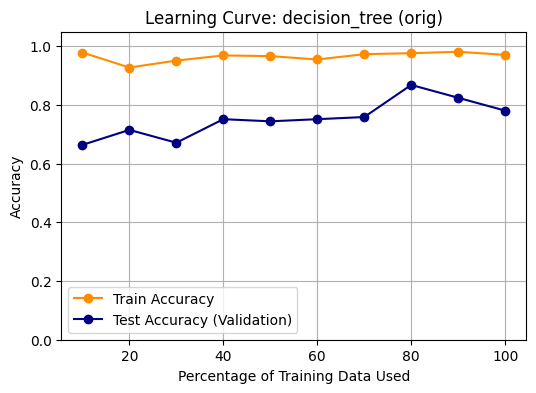

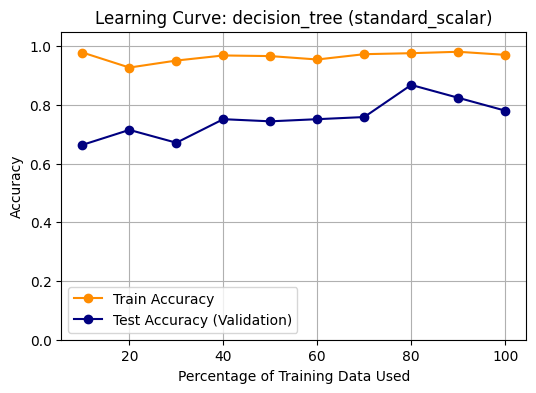

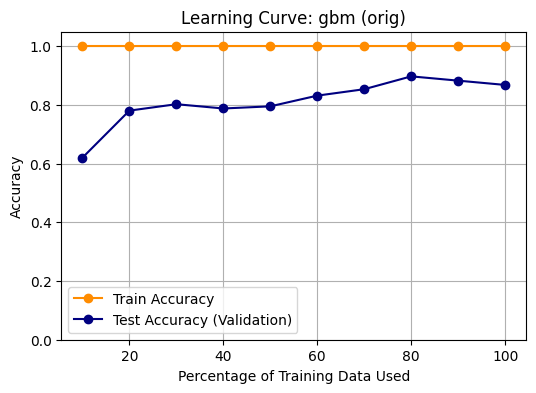

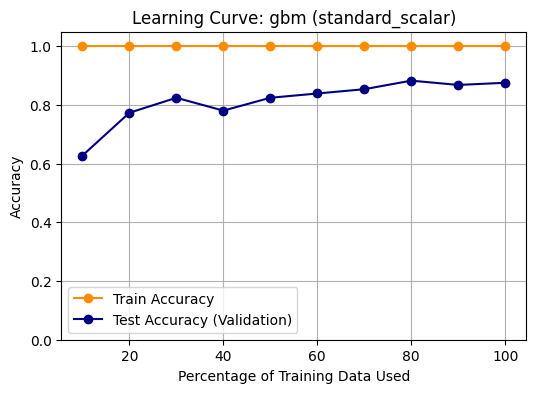

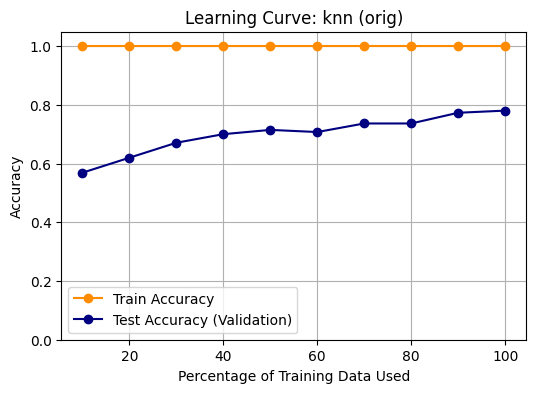

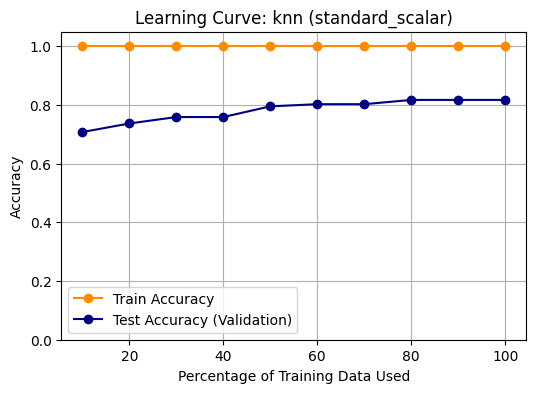

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed

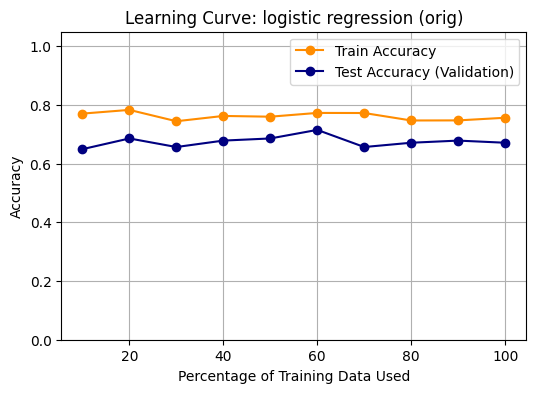

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_

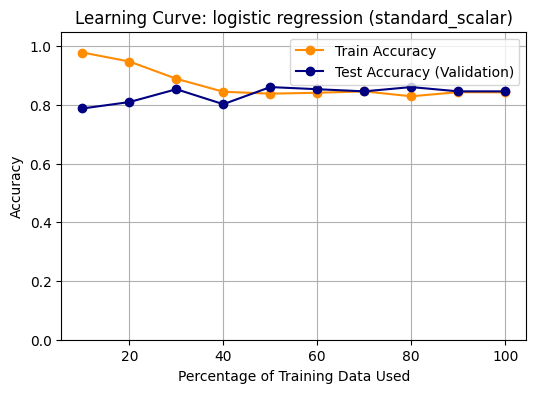

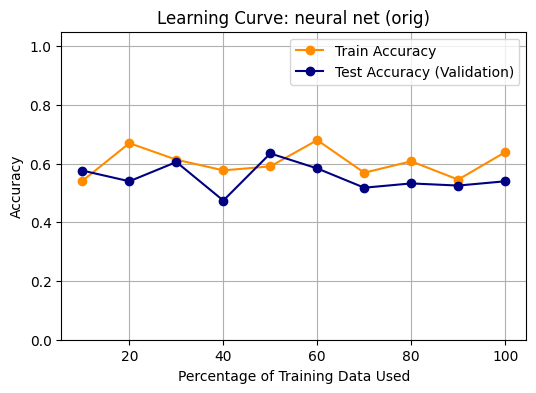

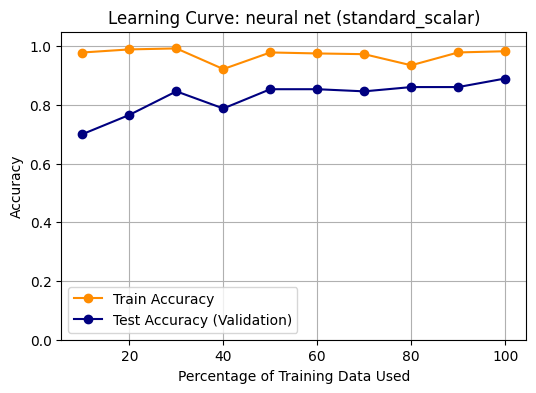

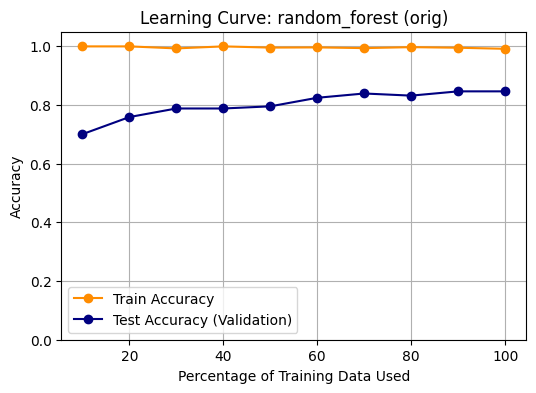

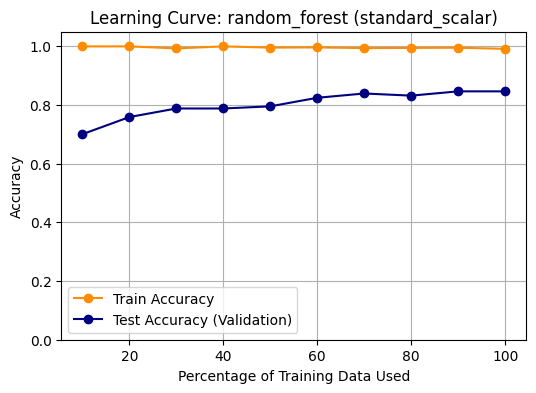

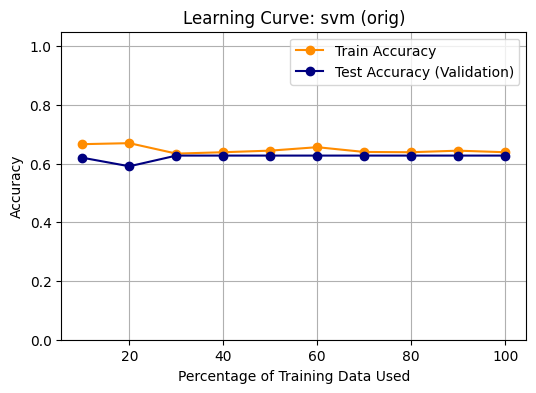

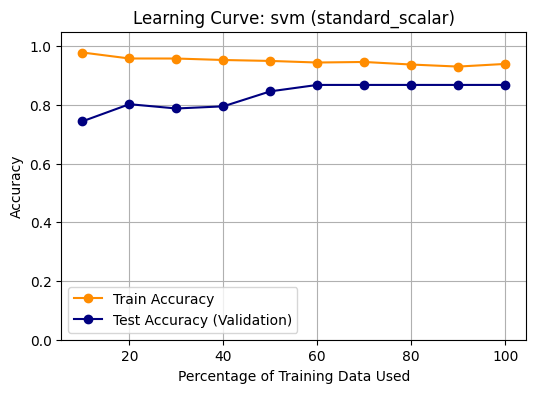

In [114]:
# Loading current data
df_curr = data_prep(file_info)
data_testing_curr = get_train_test(df_curr, y_col=Y_COL, scaling_used=True)

# Define Training Split Sizes (10% to 100% of training data)
train_fractions = np.linspace(0.1, 1.0, 10)

def get_best_estimator(row):
    """Reconstructs the model object from the best results row."""
    name = row['model used']

    # Helper to clean params (handle NaNs)
    def get_param(col, default=None, dtype=float):
        val = row.get(col)
        if pd.isna(val):
            return default
        if dtype == int:
            return int(val)
        return val

    if name == 'logistic regression':
        return LogisticRegression(
            C=get_param('logistic_reg_c', 1.0),
            l1_ratio=get_param('lr_ratios', 0.0),
            max_iter=1000
        )
    elif name == 'knn':
        return KNeighborsClassifier(
            n_neighbors=get_param('knn_n_neighbor', 5, int),
            weights=row.get('knn_weights', 'uniform')
        )
    elif name == 'decision_tree':
        return DecisionTreeClassifier(
            max_depth=get_param('dt_max_depth', None, int),
            min_samples_split=get_param('dt_min_samples_split', 2, int),
            random_state=RANDOM_STATE
        )
    elif name == 'random_forest':
        return RandomForestClassifier(
            n_estimators=get_param('rf_n_estimators', 100, int),
            max_depth=get_param('rf_max_depth', None, int),
            min_samples_leaf=get_param('rf_min_samples_leaf', 1, int),
            min_samples_split=get_param('rf_min_samples_split', 2, int),
            random_state=RANDOM_STATE
        )
    elif name == 'svm':
        return SVC(
            C=get_param('svm_c_val', 1.0),
            kernel=row.get('svm_kernel', 'rbf'),
            probability=True,
            max_iter=20000
        )
    elif name == 'gbm':
        return GradientBoostingClassifier(
            learning_rate=get_param('gbm_learning_rate', 0.1),
            n_estimators=get_param('gbm_n_estimator', 100, int),
            random_state=RANDOM_STATE
        )
    elif name == 'neural net':
        # Keras models need to be built freshly
        def build_nn():
            model = Sequential()
            model.add(Input(shape=(data_testing_curr['orig']['X_train'].shape[1],)))
            layers = get_param('nn_layers', 1, int)
            neurons = get_param('nn_neurons', 32, int)
            for _ in range(layers):
                model.add(Dense(neurons, activation="relu"))
            model.add(Dense(1, activation="sigmoid"))
            model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
            return model
        return build_nn()
    return None

# Loop through each best model and plot
for index, row in best_models.iterrows():
    model_name = row['model used']
    scalar = row['scalar_status']

    # Skip if scalar type doesn't match our data keys (e.g. if we added new scalar types)
    if scalar not in data_testing_curr:
        continue

    X_train_full = data_testing_curr[scalar]['X_train']
    y_train_full = data_testing_curr[scalar]['y_train']
    X_test = data_testing_curr[scalar]['X_test']
    y_test = data_testing_curr[scalar]['y_test']

    estimator = get_best_estimator(row)
    if estimator is None:
        continue

    train_scores = []
    test_scores = []

    # Iterate over subset sizes
    for frac in train_fractions:
        # Determine subset size
        # We maintain order to keep it deterministic-ish or use shuffle=False if strict slice needed
        # But here train_test_split is easier to get random subset
        if frac < 1.0:
            X_sub, _, y_sub, _ = train_test_split(
                X_train_full, y_train_full,
                train_size=frac,
                random_state=RANDOM_STATE,
                stratify=y_train_full # Keep class balance
            )
        else:
            X_sub, y_sub = X_train_full, y_train_full

        # Train and Evaluate
        if model_name == 'neural net':
            # Keras specific API
            bs = int(row.get('nn_batch_size', 32))
            ep = int(row.get('nn_epochs', 10))
            estimator.fit(X_sub, y_sub, epochs=ep, batch_size=bs, verbose=0)
            # Predict
            train_pred = (estimator.predict(X_sub, verbose=0).flatten() > 0.5).astype(int)
            test_pred = (estimator.predict(X_test, verbose=0).flatten() > 0.5).astype(int)

            train_scores.append(accuracy_score(y_sub, train_pred))
            test_scores.append(accuracy_score(y_test, test_pred))

            # Re-build for next iteration to avoid incremental learning unless desired
            # For learning curve we usually retrain from scratch
            estimator = get_best_estimator(row)

        else:
            # Scikit-learn API
            estimator.fit(X_sub, y_sub)
            train_scores.append(accuracy_score(y_sub, estimator.predict(X_sub)))
            test_scores.append(accuracy_score(y_test, estimator.predict(X_test)))

    # Plotting
    plt.figure(figsize=(6, 4))
    plt.plot(train_fractions * 100, train_scores, 'o-', label="Train Accuracy", color="darkorange")
    plt.plot(train_fractions * 100, test_scores, 'o-', label="Test Accuracy (Validation)", color="navy")
    plt.title(f"Learning Curve: {model_name} ({scalar})")
    plt.xlabel("Percentage of Training Data Used")
    plt.ylabel("Accuracy")
    plt.ylim(0.0, 1.05)
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Saving Models

In [77]:
import pickle

def save_gbm(data_testing, scalar_type, gbm_learning_rate, gbm_n_estimator, file_path):
    """
    Trains a Gradient Boosting Machine (GBM) model and saves it to a file.

    Parameters:
        data_testing: dict
            Dictionary containing processed data for training and testing.
        scalar_type: str
            The type of scaling used ('standard_scalar' or 'orig').
        gbm_learning_rate: float
            The learning rate for the GBM model.
        gbm_n_estimator: int
            The number of boosting stages to perform for the GBM model.
        file_path: str
            The path where the trained model will be saved.
    """

    X_train = data_testing[scalar_type]["X_train"]
    y_train = data_testing[scalar_type]["y_train"]

    # Initialize and train the GBM model with the specified hyperparameters
    model = GradientBoostingClassifier(
        learning_rate=gbm_learning_rate, n_estimators=gbm_n_estimator, random_state=RANDOM_STATE
    )
    model.fit(X_train, y_train)

    # Save the trained model using pickle
    with open(file_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"GBM model saved to {file_path}")
# NOTE: This function was added to resolve a NameError when trying to save GBM models.


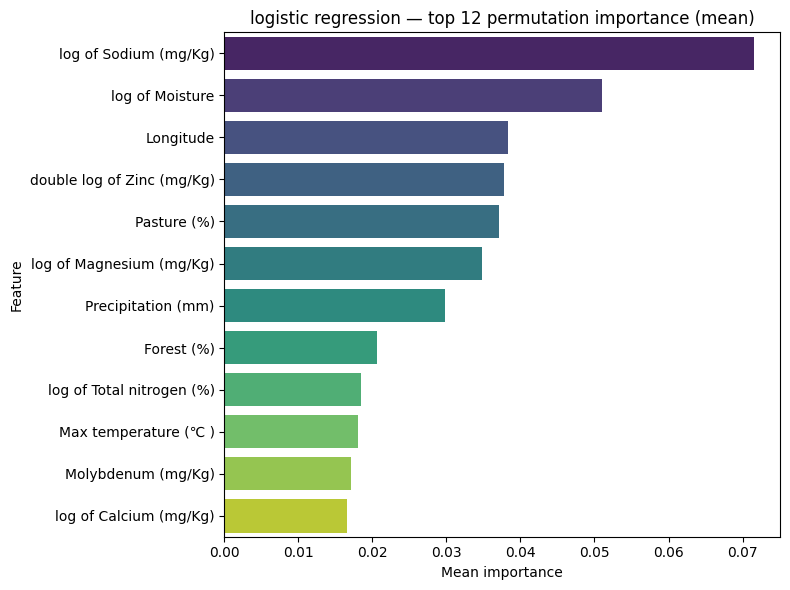

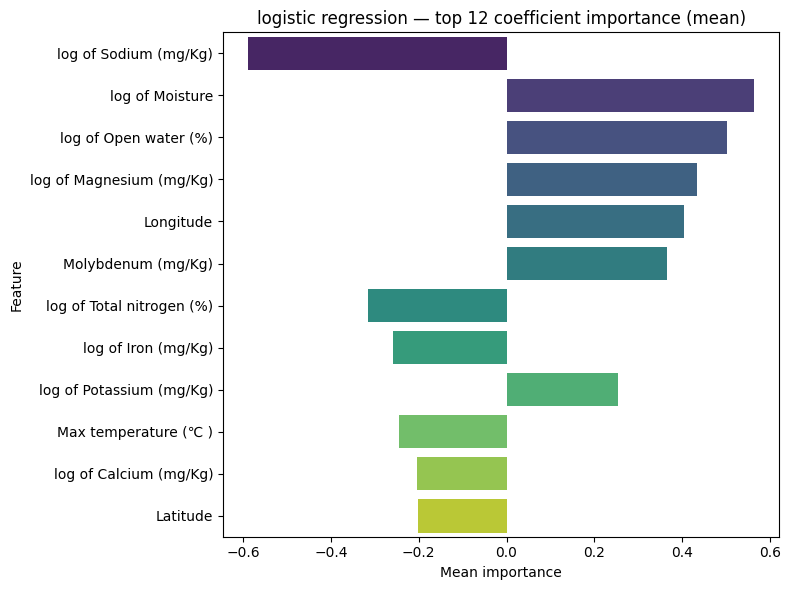

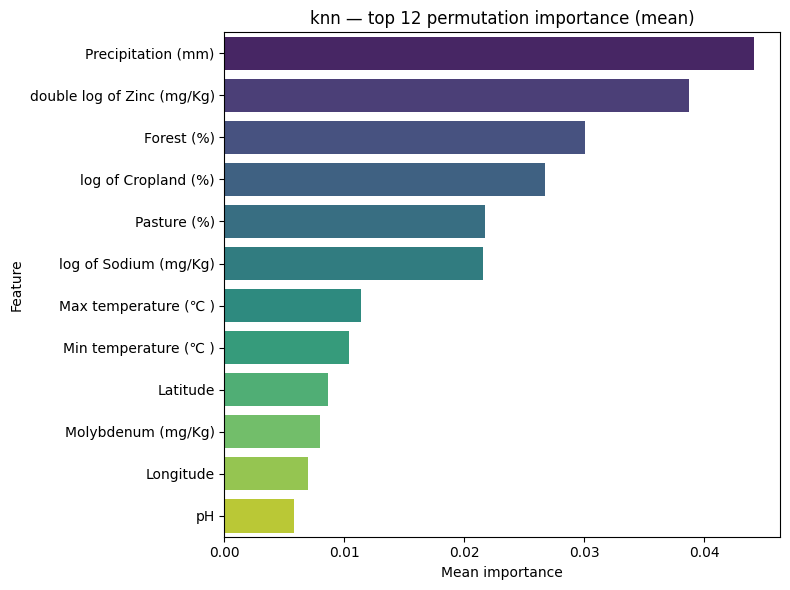

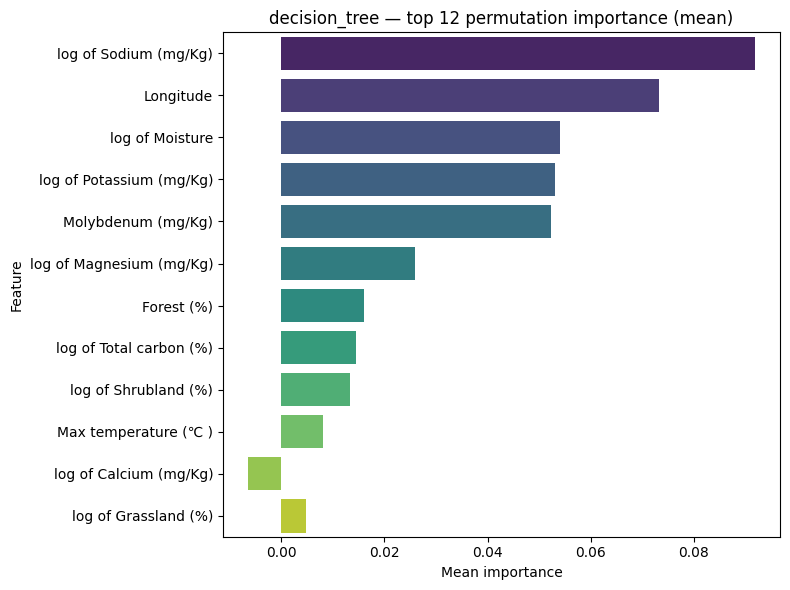

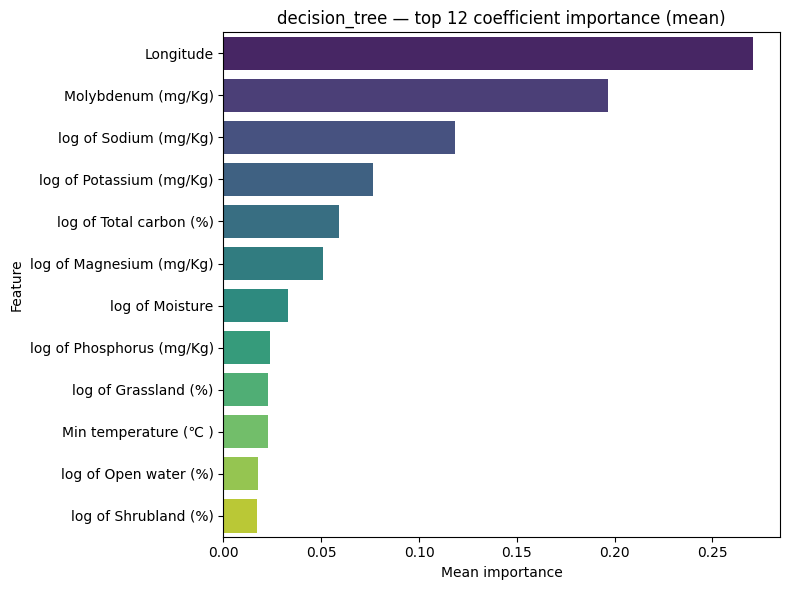

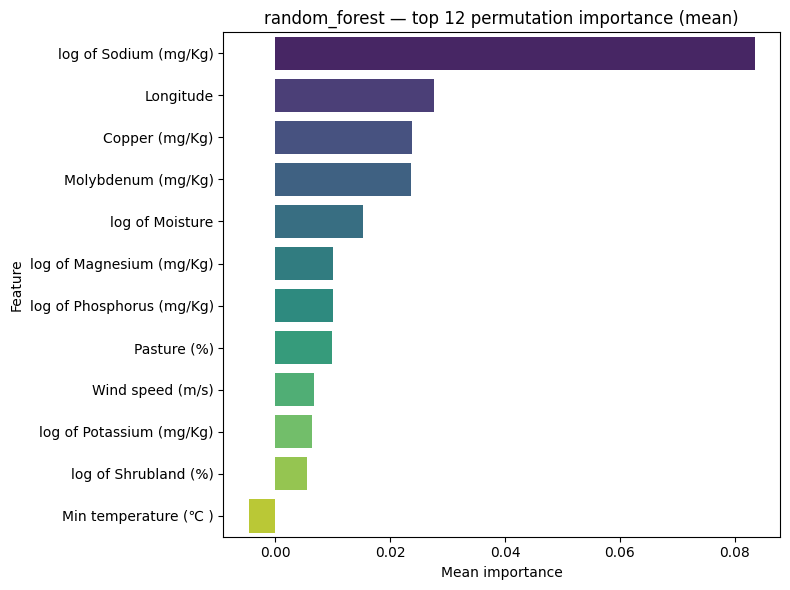

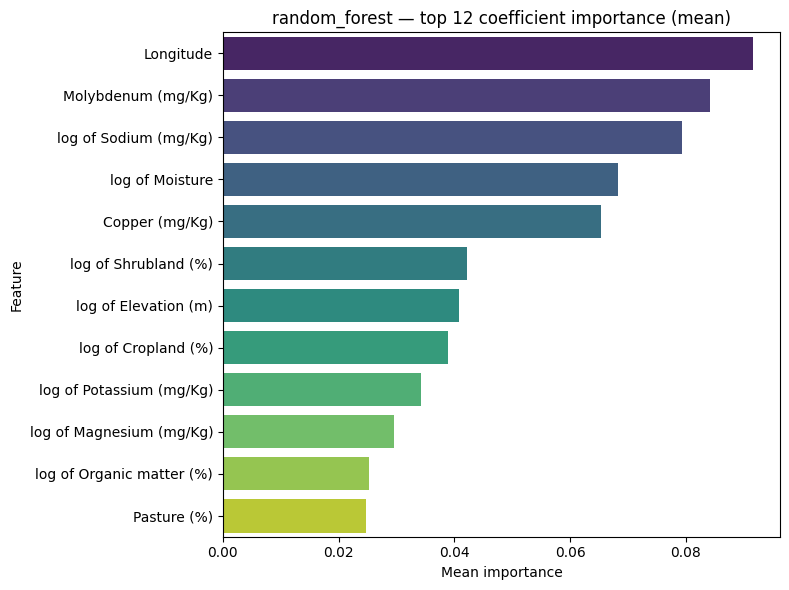

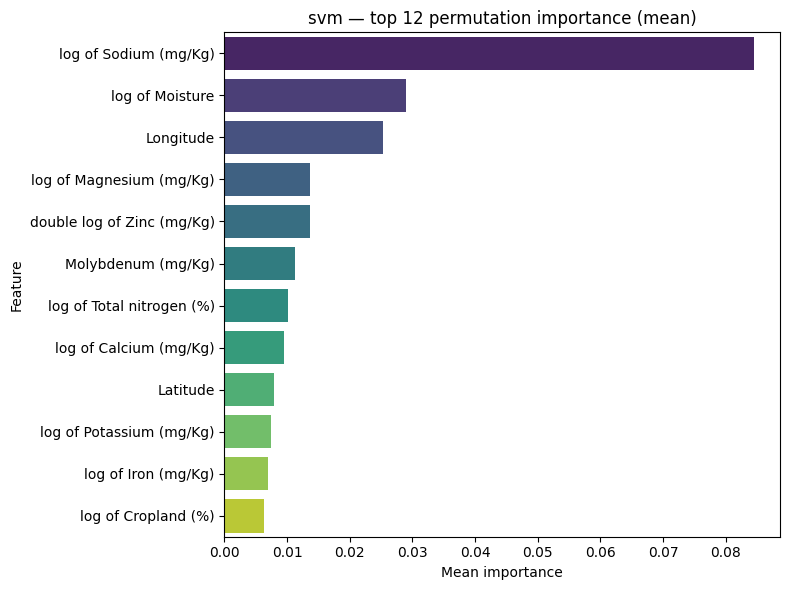

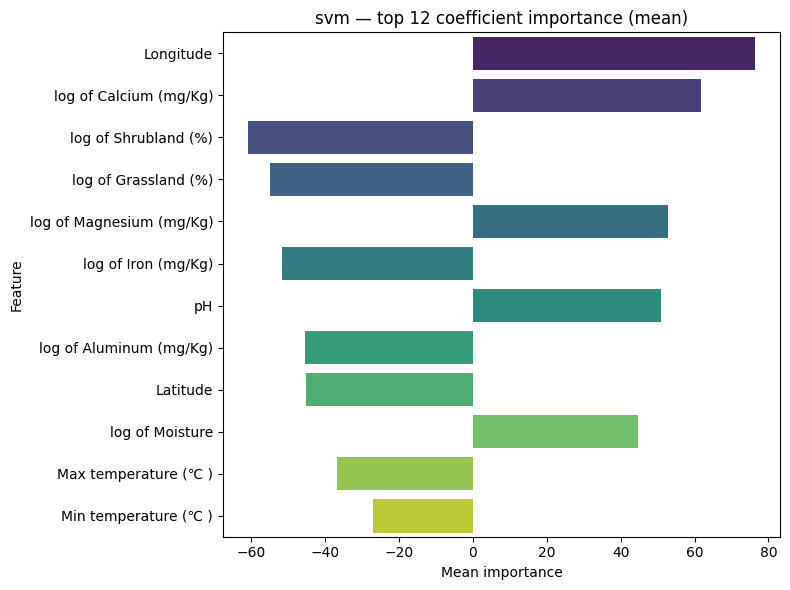

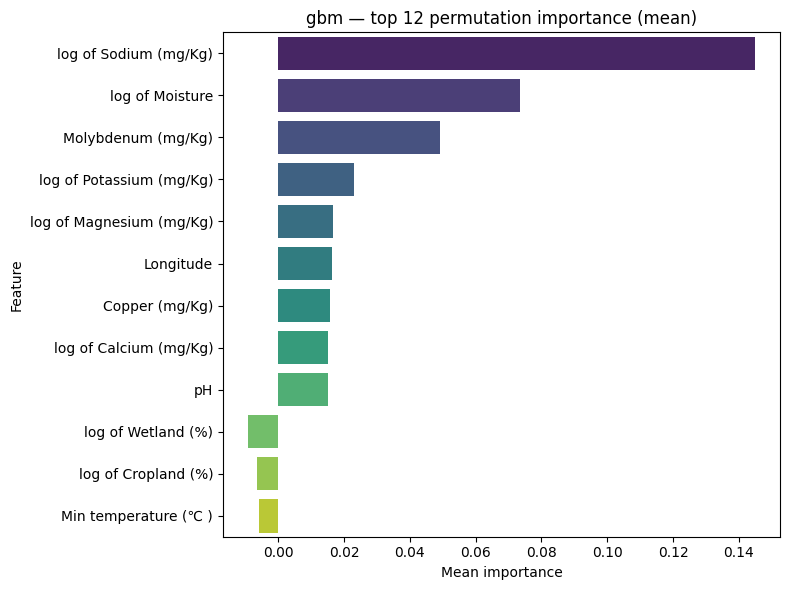

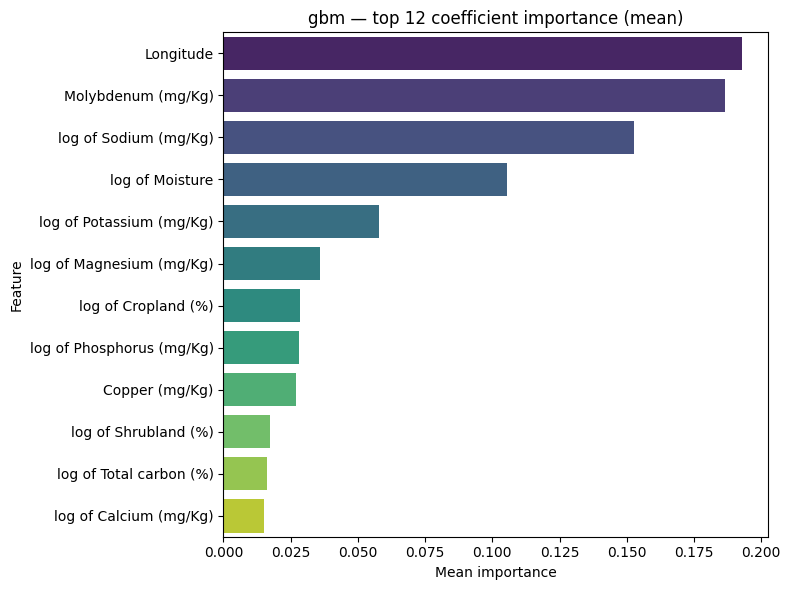

In [75]:
def plot_feature_importances(df, model_name, importance_col='permutation_importance', top_n=12):
    """
    Aggregates and plots mean feature importance for a given model.
    importance_col: 'permutation_importance' or 'coefficient_importance'.
    """
    # Filter the DataFrame for the specific model and where the importance column is not NaN
    subset = df[(df['model used'] == model_name) & df[importance_col].notna()]
    # No data to plot if the subset is empty
    if subset.empty:
        return

    rows = []
    # Iterate through each row in the filtered subset
    for _, row in subset.iterrows():
        # Parsing the importance string (which is JSON) into a dictionary
        try:
            val_str = row[importance_col]
            if pd.isna(val_str): continue
            imp_dict = json.loads(str(val_str))
        except Exception:
            continue
        # For each feature and its value in the importance dictionary
        for feat, val in imp_dict.items():
            # Append a dictionary with the feature and its importance to the rows list
            rows.append({'feature': feat, 'importance': val})

    if not rows:
        return

    # Create a DataFrame from the extracted feature importances
    # Group by feature, calculate the mean importance
    agg_df = pd.DataFrame(rows).groupby('feature')['importance'].mean()

    # Sort by absolute magnitude to capture strong negative coefficients
    agg_df_abs = agg_df.abs().sort_values(ascending=False).head(top_n)

    # Select the original values for those top N features (to show sign)
    imp_df = agg_df.loc[agg_df_abs.index]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=imp_df.values, y=imp_df.index, hue=imp_df.index, palette='viridis', legend=False)
    plt.title(f"{model_name} — top {top_n} {importance_col.replace('_', ' ')} (mean)")
    plt.xlabel('Mean importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Generate plots for each model present in the results_df
models = results_df['model used'].dropna().unique() if 'model used' in results_df.columns else []
for m in models:
    # If 'permutation_importance' column exists, plot permutation importances
    if 'permutation_importance' in results_df.columns:
        plot_feature_importances(results_df, m, 'permutation_importance', top_n=12)
    # If 'coefficient_importance' column exists, plot coefficient importances
    if 'coefficient_importance' in results_df.columns:
        plot_feature_importances(results_df, m, 'coefficient_importance', top_n=12)

In [81]:
#  saving gbm model
# hyperparams
gbm_learning_rate = 0.1
gbm_n_estimator = 400
scalar_type = "standard_scalar"


print("cwd:", Path.cwd())
print("file_info:", file_info)
print("exists:", Path(file_info).exists())
df = data_prep(file_info)
data_testing = get_train_test(df, y_col=Y_COL, scaling_used=True)

save_gbm(data_testing,  scalar_type, gbm_learning_rate, gbm_n_estimator, "input_model_file.pkl")

cwd: /content
file_info: ListeriaSoil_clean_log.csv
exists: True
GBM model saved to input_model_file.pkl


In [79]:
soil_vars_only = ['pH', 'Copper (mg/Kg)', 'Molybdenum (mg/Kg)', 'log of Sulfur (mg/Kg)', 'log of Moisture',
       'log of Manganese (mg/Kg)', 'log of Aluminum (mg/Kg)', 'log of Potassium (mg/Kg)',
       'log of Total nitrogen (%)', 'double log of Zinc (mg/Kg)', 'log of Organic matter (%)', 'log of Phosphorus (mg/Kg)',
       'log of Iron (mg/Kg)', 'log of Magnesium (mg/Kg)', 'log of Sodium (mg/Kg)', 'log of Calcium (mg/Kg)', 'scaled_cluster_kmeans', 'cluster_kmeans']
long_lat_vars_only = ['Latitude', 'Longitude',
       'Precipitation (mm)', 'Max temperature (℃ )', 'Min temperature (℃ )',
       'Wind speed (m/s)', 'Barren (%)', 'Forest (%)', 'Pasture (%)',
       'log of Grassland (%)', 'log of Shrubland (%)',
       'log of Open water (%)', 'log of Total carbon (%)',
       'log of Developed open space (> 20% Impervious Cover) (%)', 'log of Elevation (m)',
        'log of Cropland (%)', 'log of Wetland (%)', "log of Developed open space (< 20% Impervious Cover) (%)",
       'scaled_cluster_kmeans', 'cluster_kmeans']

In [82]:
# only latitude longitude accessible data
# (elevation, long/lat, and weather), aka no soil

#  saving gbm model
# hyperparams
gbm_learning_rate = 0.1
gbm_n_estimator = 400
scalar_type = "standard_scalar"


print("cwd:", Path.cwd())
print("file_info:", file_info)
print("exists:", Path(file_info).exists())
df = data_prep(file_info)

# Filter soil_vars_only to only include columns that exist in df
# NOTE: Added this filter to prevent KeyError if columns were already dropped by data_prep.
columns_to_drop = [col for col in soil_vars_only if col in df.columns]
df = df.drop(columns=columns_to_drop) # dropping soil variables to create a long lat only
# also drops clusters because those were developed with full variables.
data_testing = get_train_test(df, y_col=Y_COL, scaling_used=True)

save_gbm(data_testing,  scalar_type, gbm_learning_rate, gbm_n_estimator, "input_model_file_only_longlat.pkl")

cwd: /content
file_info: ListeriaSoil_clean_log.csv
exists: True
GBM model saved to input_model_file_only_longlat.pkl


In [84]:
# only soil data
# (moisture, soil) aka no weather or long/lat

#  saving gbm model
# hyperparams
gbm_learning_rate = 0.1
gbm_n_estimator = 400
scalar_type = "standard_scalar"


print("cwd:", Path.cwd())
print("file_info:", file_info)
print("exists:", Path(file_info).exists())
df = data_prep(file_info)

# Filter long_lat_vars_only to only include columns that exist in df
# NOTE: Added this filter to prevent KeyError if columns were already dropped by data_prep.
columns_to_drop = [col for col in long_lat_vars_only if col in df.columns]
df = df.drop(columns=columns_to_drop) # dropping long lat only
# also drops clusters because those were developed with full variables.
data_testing = get_train_test(df, y_col=Y_COL, scaling_used=True)

save_gbm(data_testing,  scalar_type, gbm_learning_rate, gbm_n_estimator, "input_model_file_only_soil.pkl")

cwd: /content
file_info: ListeriaSoil_clean_log.csv
exists: True
GBM model saved to input_model_file_only_soil.pkl
